## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [ ]:
technical_features = [
    "close_0",
    "close_sp500_0",
    "close_365",
    "close_sp500_365",
    "close__minus_120",
    "close_sp500__minus_120",
    "close__minus_365",
    "close_sp500__minus_365",
    "close__minus_730",
    "close_sp500__minus_730",
    "stock_change_365",
    "stock_change_div_365",
    "sp500_change_365",
    "stock_change__minus_120",
    "sp500_change__minus_120",
    "stock_change__minus_365",
    "sp500_change__minus_365",
    "stock_change__minus_730",
    "sp500_change__minus_730",
    "std__minus_365",
    "std__minus_730",
    "std__minus_120",
]
#

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [18]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
import os
from plotnine import (
    ggplot,
    geom_histogram,
    aes,
    geom_boxplot,
    geom_col,
    coord_flip,
    geom_bar,
    scale_x_discrete,
    geom_point,
    theme,
    element_text,
)

In [19]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [ ]:
data_set = pd.read_feather(os.path.join("financials_against_return.feather"))

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [21]:
df_quarter_lengths = (
    data_set.groupby(["execution_date"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)
data_set = pd.merge(data_set, df_quarter_lengths, on=["execution_date"])
data_set = data_set[data_set["count"] >= minimum_number_of_tickers]

In [22]:
data_set.shape

(170483, 145)

In [23]:
data_set.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773,1962
1,NDSN,2005-01-31,0.2248,-3.366,10.663,7.700,62.6220,NaN,NaN,-21.145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846,1962
2,HURC,2005-01-31,0.3782,0.483,-0.400,2.866,11.3030,0.156,0.854,-0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440,1962
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322,1962
4,HRL,2005-01-31,0.4880,-12.075,-113.077,83.476,145.2050,NaN,17.084,3.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482,1962


In [24]:
data_set.dtypes

Ticker                                     object
date                               datetime64[ns]
AssetTurnover                             float64
CashFlowFromFinancialActivities           float64
CashFlowFromInvestingActivities           float64
                                        ...      
CurrentRatio_change_2_years               float64
Market_cap__minus_365                     float64
Market_cap__minus_730                     float64
diff_ch_sp500                             float64
count                                       int64
Length: 145, dtype: object

In [25]:
data_set.isna().sum()

Ticker                                 0
date                                   0
AssetTurnover                       7114
CashFlowFromFinancialActivities     1940
CashFlowFromInvestingActivities     1930
                                   ...  
CurrentRatio_change_2_years        59767
Market_cap__minus_365              15242
Market_cap__minus_730              29386
diff_ch_sp500                      14217
count                                  0
Length: 145, dtype: int64

# Target creation

In [26]:
data_set["diff_ch_sp500"] = (
    data_set["stock_change_div_365"] - data_set["sp500_change_365"]
)

data_set.loc[data_set["diff_ch_sp500"] > 0, "target"] = 1
data_set.loc[data_set["diff_ch_sp500"] < 0, "target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

In [27]:
data_set["target"].isna().sum()

14217

# My outcome

This notebook:
- Creates a baseline to compare model's performance.
- Draws the learning curves to see the model's learning process
- Studies the distribution of train/test in every execution date (with this part I've found some problems)
- Hyperparameter tunning to avoid overfitting
- Data importance with permutation method to study the reason of its predictions. Shap in specific cases.
- Retraining it without data leackeage and with the most important features
- Study of quarter reduction

# Functions for weighted performance of top stocks

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [28]:
def get_weighted_performance_of_stocks(df, metric):
    df["norm_prob"] = 1 / len(df)
    return np.sum(df["norm_prob"] * df[metric])


def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert "Not matching train/test"
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending=False)
    data_set = data_set.head(top_n)
    return data_set


# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return (
        "weighted-return",
        get_weighted_performance_of_stocks(top_dataset, "diff_ch_sp500"),
        True,
    )


# Fuction to evaluate accuracy of the top_n companies
def get_accuracy_of_stocks(top_dataset, metric):
    return top_dataset[metric].sum() / top_n


def top_accuracy(pred, train_data):
    top_dataset = get_top_tickers_per_prob(pred)
    return "accuracy", get_accuracy_of_stocks(top_dataset, "target"), True

# Temporal train-test split

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [29]:
def split_train_test_by_period(
    data_set, test_execution_date, include_nulls_in_test=False
):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[
        data_set["execution_date"]
        <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit="day")
    ]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters != None:
        train_set = train_set[
            train_set["execution_date"].isin(execution_dates[-n_train_quarters:])
        ]

    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values("date", ascending=False).drop_duplicates(
        "Ticker", keep="first"
    )

    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [30]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp500_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date",
        "target",
        "index",
        "quarter",
        "std_730",
        "count",
    ]

    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [31]:
import warnings

warnings.filterwarnings("ignore")


def train_model(train_set, test_set, params):

    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance, top_accuracy],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result, X_train, X_test

# Trains and evaluates a model

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [32]:
def run_model_for_execution_date(
    execution_date,
    all_results,
    all_predicted_tickers_list,
    all_models,
    params,
    include_nulls_in_test=False,
):
    global train_set
    global test_set
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = train_set
    X_test = test_set

    # if both train and test are not empty
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test = train_model(
            train_set, test_set, params=params
        )

        test_set["prob"] = model.predict(X_test)
        predicted_tickers = test_set.sort_values("prob", ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test


execution_dates = np.sort(data_set["execution_date"].unique())

# Loop for every execution date

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [33]:
def train_model_across_periods(params):
    all_results = {}
    all_predicted_tickers_list = []
    all_models = {}

    for execution_date in execution_dates:
        print(execution_date)
        all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = (
            run_model_for_execution_date(
                execution_date,
                all_results,
                all_predicted_tickers_list,
                all_models,
                params,
                False,
            )
        )
    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

    return all_results, all_predicted_tickers_list, all_predicted_tickers, all_models

In [34]:
objective = "binary"
metric = "binary_logloss"
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "n_estimators": n_trees,
    "objective": objective,
    "metric": metric,
}
all_results, all_predicted_tickers_list, all_predicted_tickers, all_models = (
    train_model_across_periods(params)
)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [36]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    df["execution_date"] = df["execution_date"].astype(str)

    return df

In [37]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [38]:
print(train_results.head(3))
print(test_results.head(3))

   binary_logloss  weighted-return  accuracy  n_trees execution_date
0        0.657505         0.267845       1.0        0     2006-06-30
1        0.639193         0.483940       1.0        1     2006-06-30
2        0.619754         0.218716       1.0        2     2006-06-30
   binary_logloss  weighted-return  accuracy  n_trees execution_date
0        0.718962         0.193742       0.5        0     2006-06-30
1        0.716195         0.246123       0.7        1     2006-06-30
2        0.715489         0.267459       0.5        2     2006-06-30


In [39]:
# Last tree result for each execution date
test_results_final_tree = test_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
test_results_final_tree["execution_date"] = pd.to_datetime(
    test_results_final_tree["execution_date"]
)
train_results_final_tree["execution_date"] = pd.to_datetime(
    train_results_final_tree["execution_date"]
)

And these are the results:

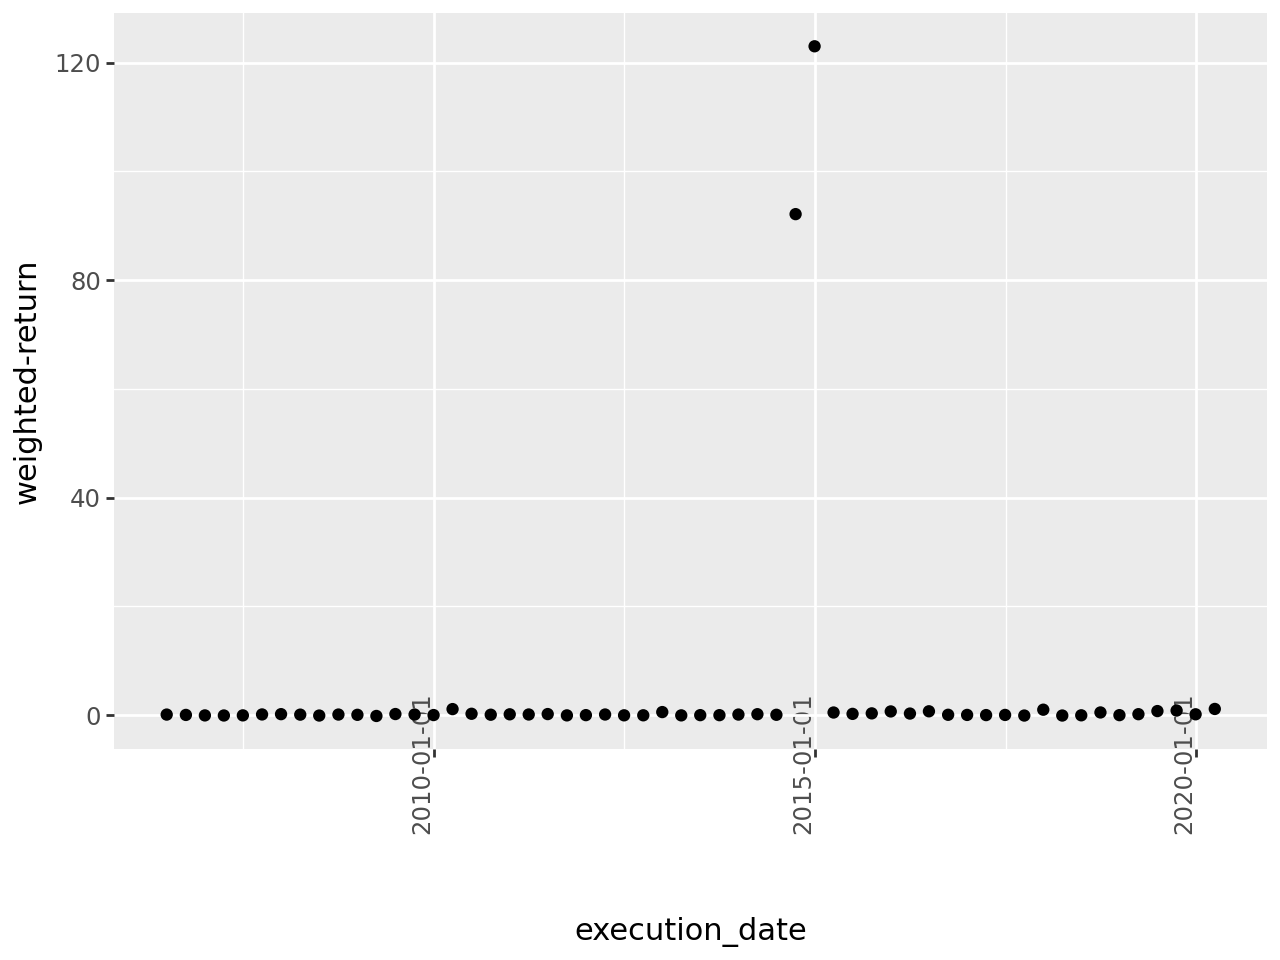

In [40]:
(
    ggplot(test_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)
# Representing the weighted-return of the final test tree every execution-date

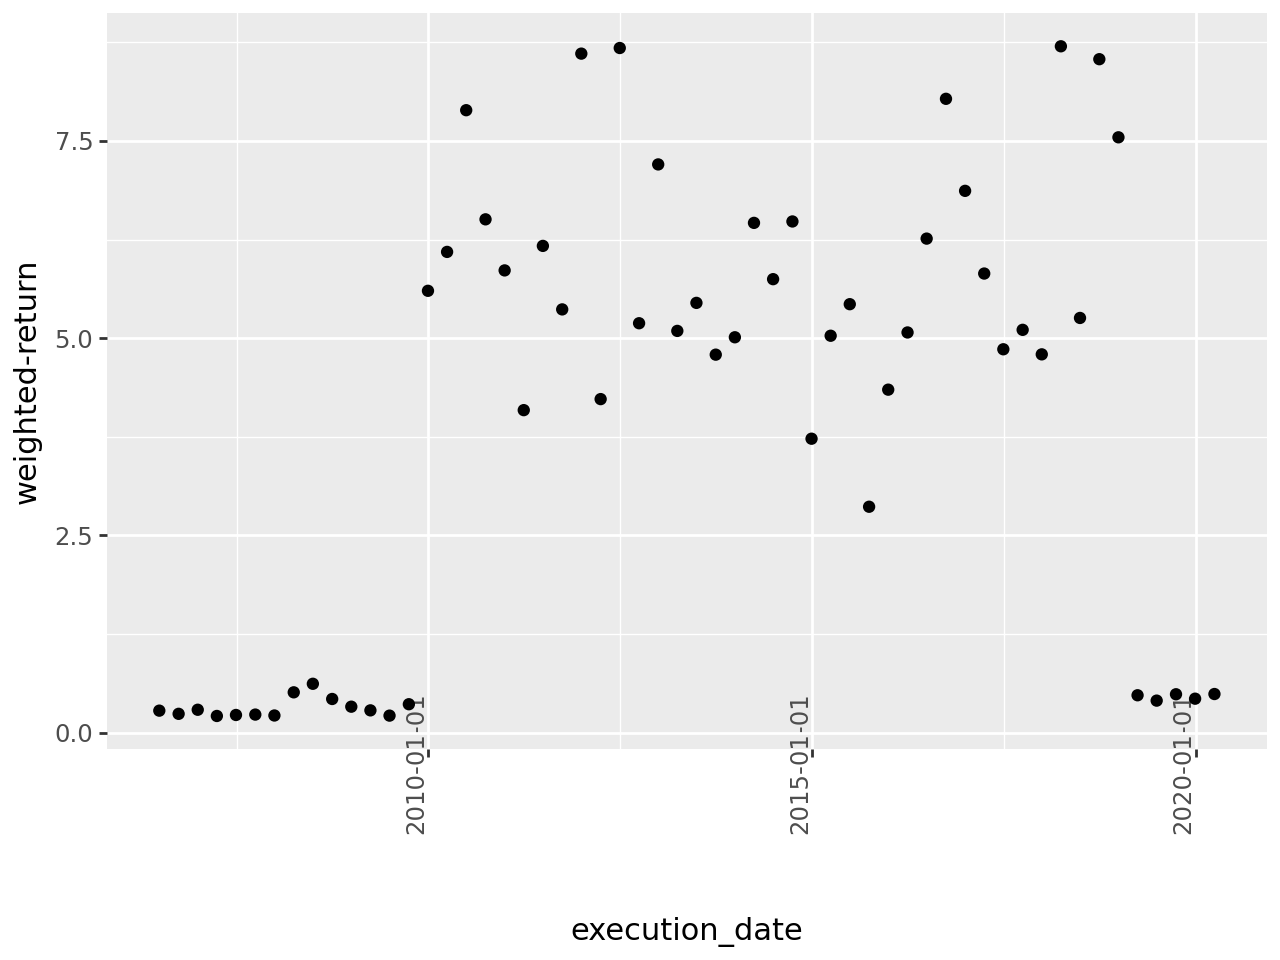

In [41]:
(
    ggplot(train_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)
# Representing the weighted-return of the final train tree every execution-date

# Baseline

Let's supose that the stocks with good performance in the previous quarter wil continuo having a good performance in the following year. In this way, I'm going to assume that the top 10 companies 120 days before the execution date are the top 10 companies a year after the execution date.

In [42]:
def baseline_predictions(all_predicted_tickers):
    # Calculating the diff_ch_sp500_minus_120
    all_predicted_tickers["diff_ch_sp500_minus_120"] = (
        all_predicted_tickers["stock_change__minus_120"]
        - all_predicted_tickers["sp500_change__minus_120"]
    )
    all_predicted_tickers = all_predicted_tickers.sort_values(
        ["execution_date", "diff_ch_sp500_minus_120"], ascending=False
    )
    all_predicted_tickers["rank"] = all_predicted_tickers.groupby(
        ["execution_date"]
    ).cumcount()
    # Selecting the top 10 with best return
    all_predicted_tickers_top_diff = all_predicted_tickers[
        all_predicted_tickers["rank"] < 10
    ]
    baseline = (
        all_predicted_tickers_top_diff.groupby("execution_date")["diff_ch_sp500"]
        .mean()
        .reset_index()
    )
    baseline = baseline.rename(columns={"diff_ch_sp500": "diff_ch_sp500_baseline"})
    return baseline

In [43]:
baseline = baseline_predictions(all_predicted_tickers)
baseline.head(2)

,execution_date,diff_ch_sp500_baseline
0,2006-06-30,-0.051974
1,2006-09-30,0.284753


In [44]:
test_results_final_tree_model_vs_baseline = pd.merge(
    test_results_final_tree, baseline, on="execution_date"
)
train_results_final_tree_model_vs_baseline = pd.merge(
    train_results_final_tree, baseline, on="execution_date"
)

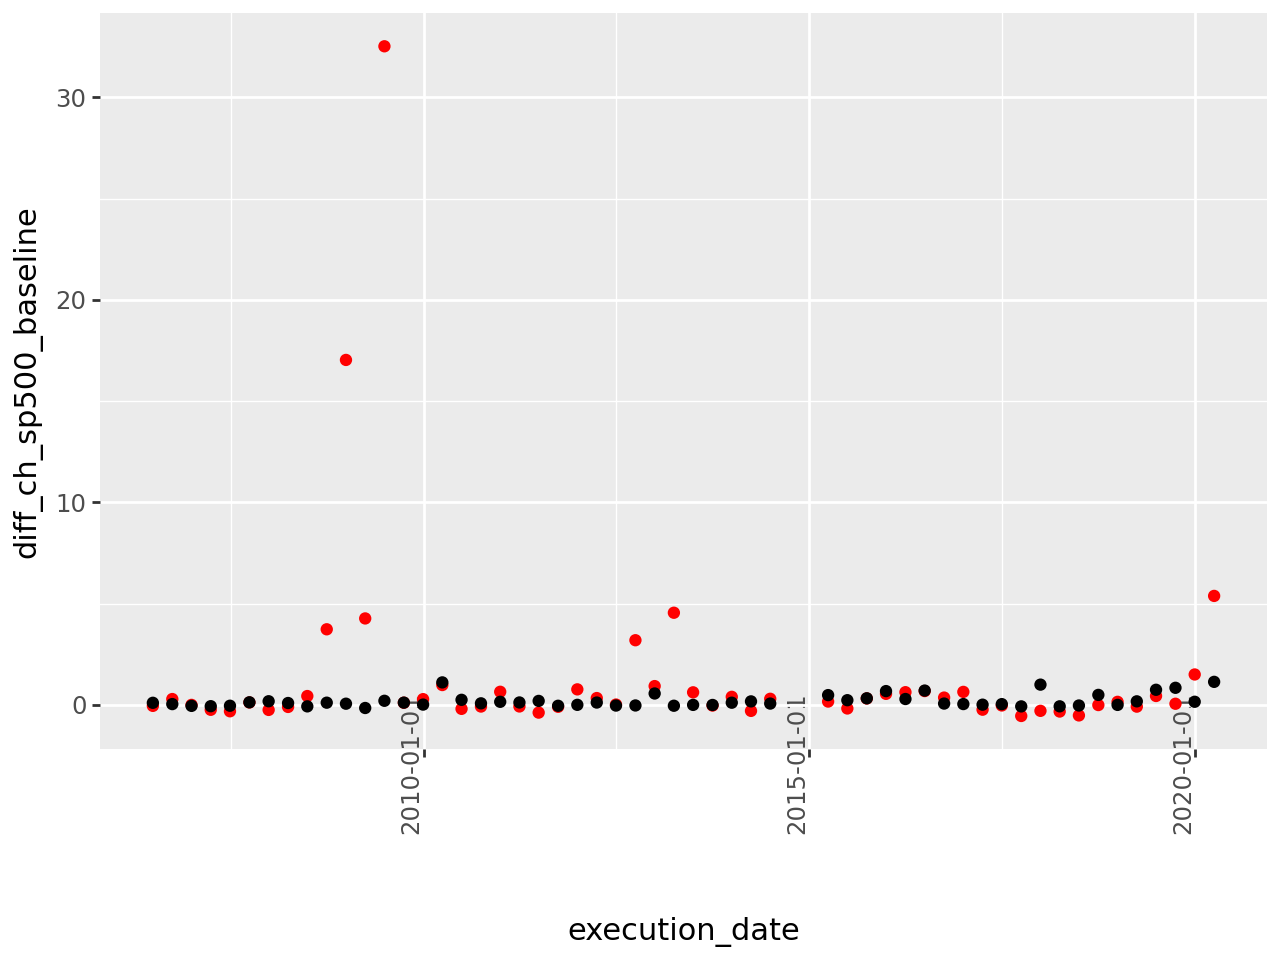

In [94]:
(
    ggplot(
        test_results_final_tree_model_vs_baseline[
            test_results_final_tree_model_vs_baseline["weighted-return"] < 2
        ],
        aes(x="execution_date"),
    )
    + geom_point(aes(y="diff_ch_sp500_baseline"), color="red")
    + geom_point(aes(y="weighted-return"), color="black")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

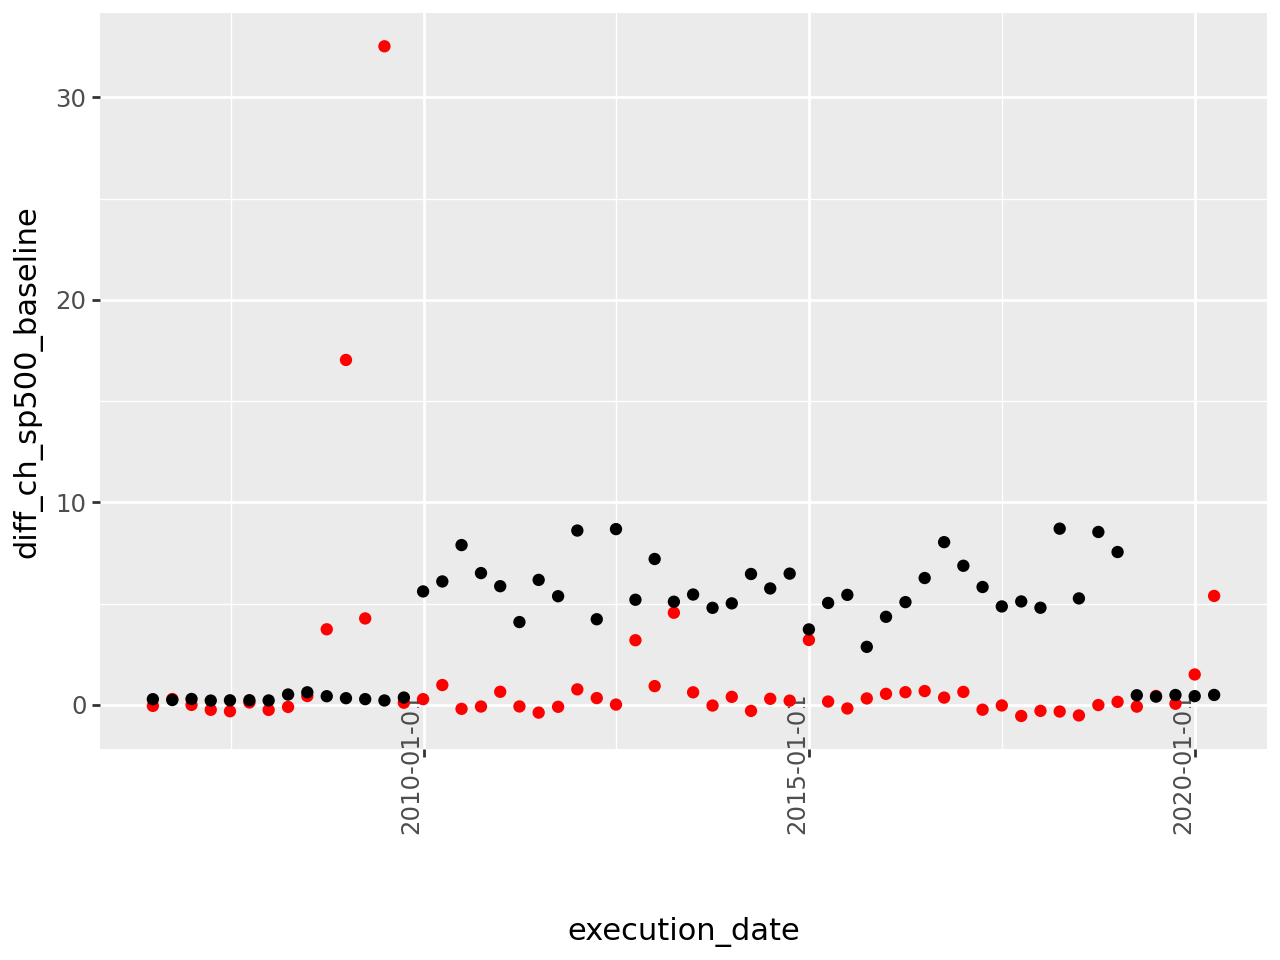

In [46]:
(
    ggplot(train_results_final_tree_model_vs_baseline, aes(x="execution_date"))
    + geom_point(aes(y="diff_ch_sp500_baseline"), color="red")
    + geom_point(aes(y="weighted-return"), color="black")
    + theme(axis_text_x=element_text(angle=90, hjust=1, vjust=0.5))
)

We can see good performance in some execution dates for the baseline, but this happens in irregular and random execution dates, it hasn´t show a trend.

# Log loss and accuracy learning curves

In [55]:
def return_norm_learning_curves(set_, all_results):
    # Dataframe for each execution_dates: n_trees (1-40), saved metrics (in each metric)
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[(date)][set_])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])
    # Merge with normal features. Normalizing all the metrics with respect to the first tree in every date
    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date", "accuracy"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(
                ["execution_date"]
            )
            # Taking the metrics of the first tree
            first_metric = first_metric.rename(columns={column: "first_" + column})
            # Merge the first metrics to the execution date & trees dataframe
            learning_curves = pd.merge(
                learning_curves, first_metric, on=["execution_date"]
            )
            # Calculating the norm metrics substracting from the value in the first tree
            learning_curves["norm_" + column] = (
                learning_curves[column] - learning_curves["first_" + column]
            ) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)

    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)
    return learning_curves

In [197]:
# Accuracy is not normalized
train_lc = return_norm_learning_curves("training", all_results)
test_lc = return_norm_learning_curves("valid_0", all_results)
train_lc["n_trees_cat"] = pd.Categorical(
    train_lc["n_trees"], categories=sorted(train_lc["n_trees"].unique())
)
test_lc["n_trees_cat"] = pd.Categorical(
    test_lc["n_trees"], categories=sorted(test_lc["n_trees"].unique())
)

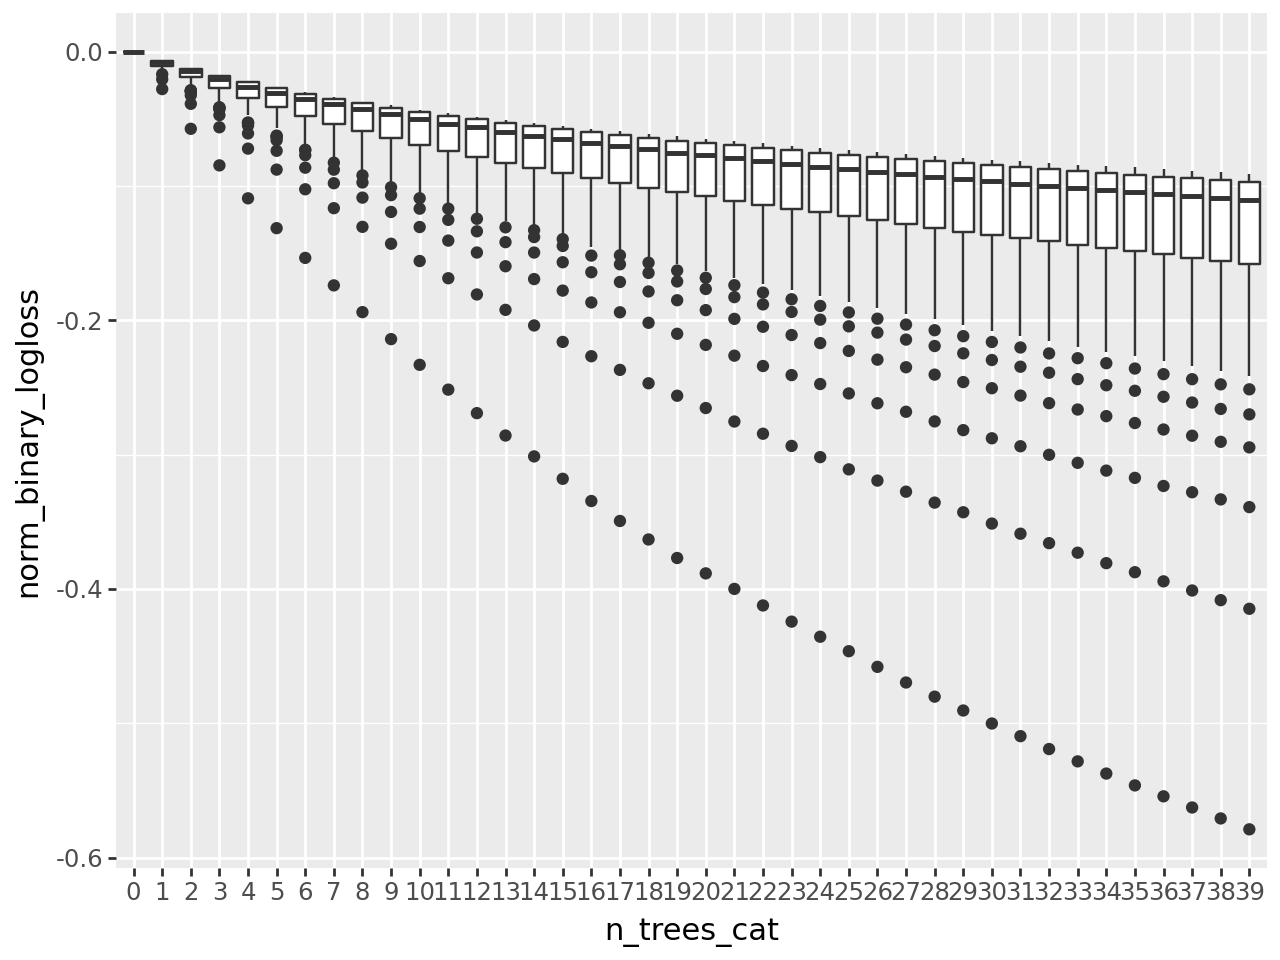

In [198]:
ggplot(train_lc) + aes(x="n_trees_cat", y="norm_binary_logloss") + geom_boxplot()

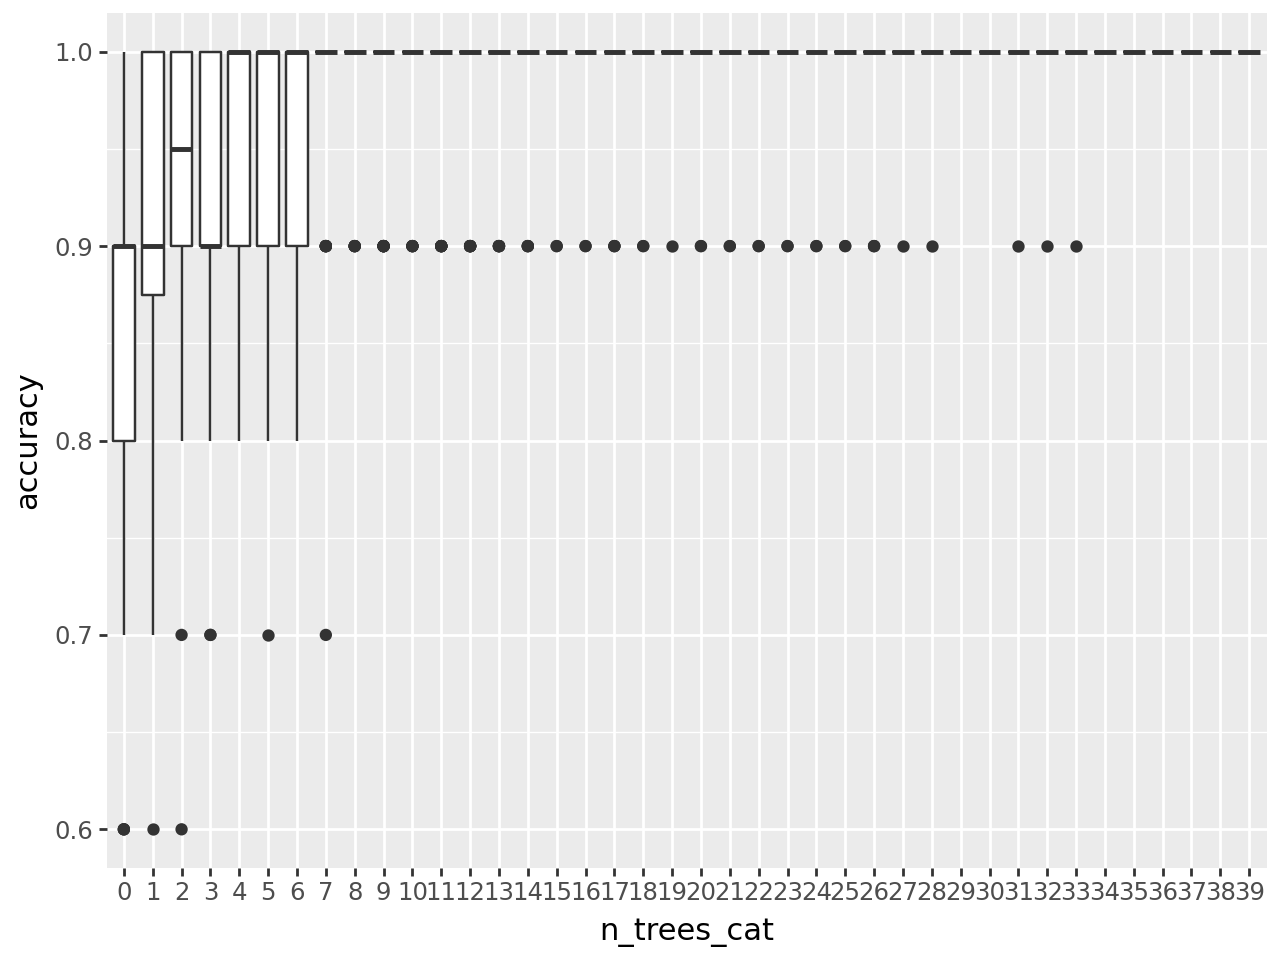

In [199]:
ggplot(train_lc) + aes(x="n_trees_cat", y="accuracy") + geom_boxplot()

In the training data, examining the log loss shows that both the median and the third quartile decrease as the number of trees increases. Additionally, there are no high outliers, but there are some low outliers. This graph indicates that learning is indeed taking place, but we cannot conclude whether it is generalizing or just learning data training.

Regarding accuracy, median values above 0.9 are achieved starting from the third tree. Finally, a median accuracy of 1 is reached for all execution dates from the seventh tree onward. This translates to the model correctly selecting all 10 companies for the portfolio on every execution date, except in some outliers where it correctly selects 9.

Test results

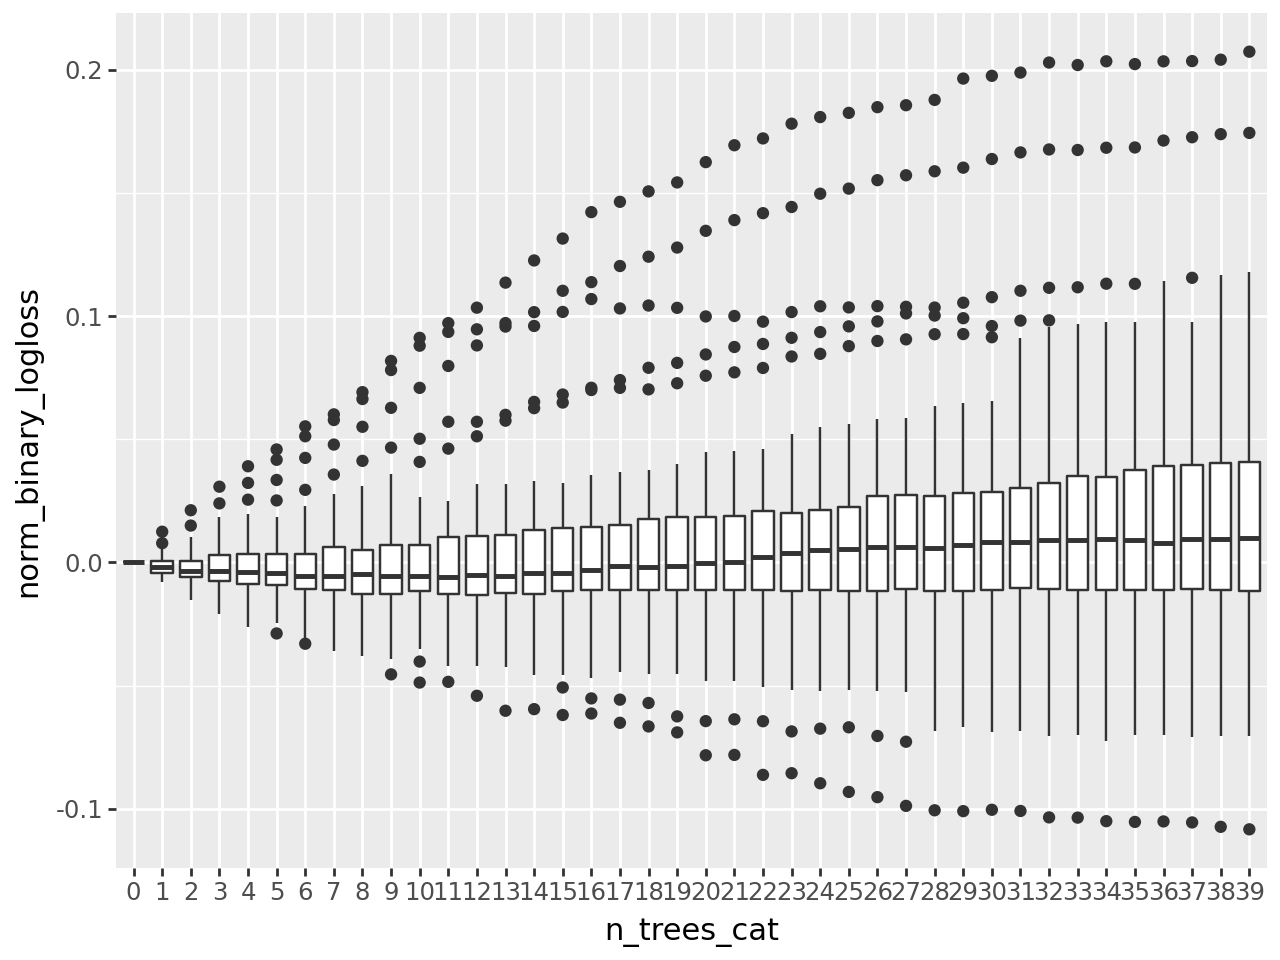

In [200]:
ggplot(test_lc) + aes(x="n_trees_cat", y="norm_binary_logloss") + geom_boxplot()

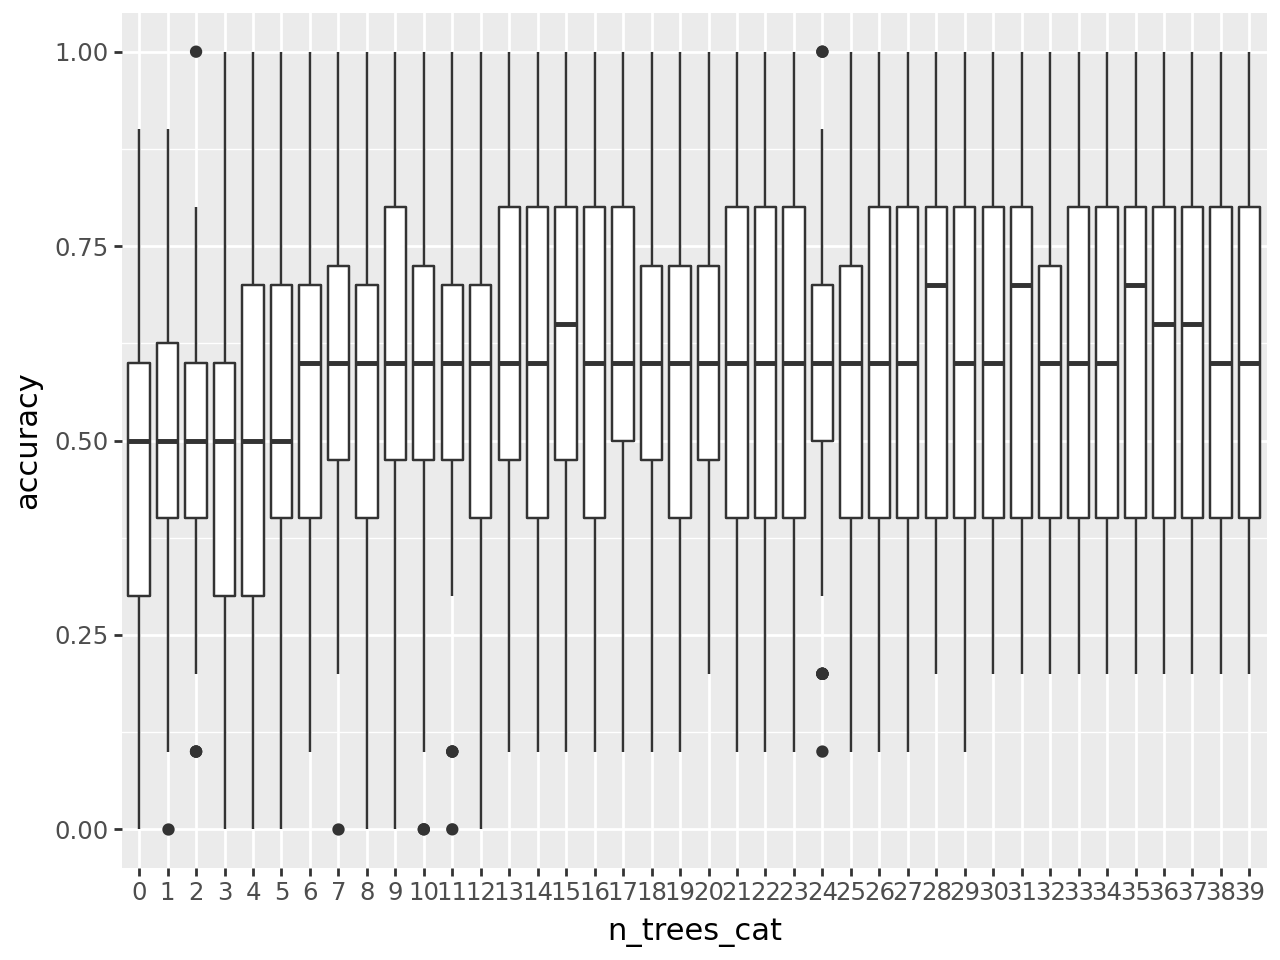

In [201]:
ggplot(test_lc) + aes(x="n_trees_cat", y="accuracy") + geom_boxplot()

There is a significant change in the log loss and accuracy values in the test subset:

- Neither the log loss median, Q3, nor Q1 decrease beyond the 10th tree.
- Many values are above 0.0, including outliers and even points within the boxplot.
- Almost no outliers fall below 0.0. The minimum log loss reached in test is -0.12 (with one outlier), whereas in training, the boxplot values were concentrated between 0.0 and -0.2.
- As for accuracy, performance is notably different from the training set. Median values mostly hover around 0.6, occasionally reaching a maximum of 0.7. Additionally, the model stops learning after the sixth tree, as no growth is observed in any quartile or the median.
- There is high variability in the values for both accuracy and log loss after.

From all these observations, it is evident that the model is overfitting to the training data, resulting in low and variable results on the test data. Hyperparameter tuning will be used to avoid this overfitting and to achieve similar metrics for both the training and validation data, ensuring that the model is both learning and generalizing.

Before hyperparameter tunning: decide splits training, validation and test for hyperparameter tuning. Study distributions train-val and train-test.
- To study the distribution first we label with 0 training and 1 val/test (dropping original label). Trainig classifier with original features and new labels and studying auc far to 0.5 because it cant distinguish because they have the same distribution. Besides, I can do feature importance to detect those variables that are more different between those subsets.

# Data distributions from different years

The study will examine whether the data from the quarters used for training follows the same distribution as the test data from the following year using a classifier. The goal is to check if the AUC is close to 0.5 and to create a histogram of the AUC values for all execution dates.

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve,
    auc,
    roc_curve,
    roc_auc_score,
    average_precision_score,
)

In [48]:
def evaluate_model(
    clf,
    X_train,
    y_train,
    X_val,
    y_val,
    train_aucs_list,
    val_aucs_list,
    train_aps_list,
    val_aps_list,
):
    train_preds = clf.predict_proba(X_train)[:, 1]
    val_preds = clf.predict_proba(X_val)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)
    val_auc = roc_auc_score(y_val, val_preds)
    train_ap = average_precision_score(y_train, train_preds)
    val_ap = average_precision_score(y_val, val_preds)

    train_aucs_list.append(train_auc)
    val_aucs_list.append(val_auc)
    train_aps_list.append(train_ap)
    val_aps_list.append(val_ap)

The chosen classifier is a simple XGBoost, I couldn't use a simpler one as DecissionTrees because they don't support NaN values, dropping them means taking off a lot of data

In [51]:
from xgboost import XGBClassifier


def suffling_train_test_data(data_set, execution_date, include_nulls_in_test=False):
    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    train_set["is_test"] = 0
    test_set["is_test"] = 1
    columns_to_remove = get_columns_to_remove()
    total_set = pd.concat([train_set, test_set], axis=0, ignore_index=True)
    total_set = total_set.drop(columns=columns_to_remove + ["target"], errors="ignore")
    X = total_set.drop(columns=["is_test"])
    y = total_set["is_test"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test


def train_clasif_across_periods(data_set):
    xg_train_aucs_list = []
    xg_test_aucs_list = []
    xg_train_aps_list = []
    xg_test_aps_list = []
    for execution_date in execution_dates[4:-4]:
        X_train, X_test, y_train, y_test = suffling_train_test_data(
            data_set, execution_date, include_nulls_in_test=False
        )
        # X_train.replace(np.inf, np.nan, inplace=True)
        # print(X_train.iloc[:,0:80])
        xg = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=10)
        xg.fit(X_train.iloc[:, 0:80], y_train)
        evaluate_model(
            xg,
            X_train.iloc[:, 0:80],
            y_train,
            X_test.iloc[:, 0:80],
            y_test,
            xg_train_aucs_list,
            xg_test_aucs_list,
            xg_train_aps_list,
            xg_test_aps_list,
        )

        print(
            f"Execution date={execution_date}: train_auc= {xg_train_aucs_list[-1]:.4f} and val_auc= {xg_test_aucs_list[-1]:.4f}."
            f" Train_ap= {xg_train_aps_list[-1]:.4f} and val_ap= {xg_test_aps_list[-1]:.4f}."
        )
    return xg_train_aucs_list, xg_test_aucs_list, xg_train_aps_list, xg_test_aps_list

In [52]:
xg_train_aucs_list, xg_test_aucs_list, xg_train_aps_list, xg_test_aps_list = (
    train_clasif_across_periods(data_set)
)

Execution date=2006-06-30T00:00:00.000000000: train_auc= 0.8199 and val_auc= 0.6994. Train_ap= 0.8197 and val_ap= 0.7117.
Execution date=2006-09-30T00:00:00.000000000: train_auc= 0.8332 and val_auc= 0.7735. Train_ap= 0.7072 and val_ap= 0.6104.
Execution date=2006-12-30T00:00:00.000000000: train_auc= 0.7995 and val_auc= 0.7499. Train_ap= 0.5686 and val_ap= 0.5122.
Execution date=2007-03-31T00:00:00.000000000: train_auc= 0.7964 and val_auc= 0.7468. Train_ap= 0.5377 and val_ap= 0.4818.
Execution date=2007-06-30T00:00:00.000000000: train_auc= 0.8179 and val_auc= 0.7843. Train_ap= 0.4517 and val_ap= 0.3921.
Execution date=2007-09-30T00:00:00.000000000: train_auc= 0.7637 and val_auc= 0.7250. Train_ap= 0.3434 and val_ap= 0.2871.
Execution date=2007-12-30T00:00:00.000000000: train_auc= 0.7450 and val_auc= 0.6671. Train_ap= 0.3011 and val_ap= 0.2110.
Execution date=2008-03-31T00:00:00.000000000: train_auc= 0.7224 and val_auc= 0.6726. Train_ap= 0.2724 and val_ap= 0.1935.
Execution date=2008-06-3

- val_auc >> 0.5. This means that theye have different distributions
- I needed to select X_train.iloc[:,0:80] because with more features it told me an error of 'infinite values'

# Hyperparameter tunning

The hyperparameters that will be adjusted to regulate overfitting are n_estimators, learning_rate, and path_smooth. Since there isn't much data—only 64 execution_dates—I won't iterate too much over the reduced validation set.

In [53]:
n_estimators = [15, 20]
results_hyp = {}
for n_estimator in n_estimators:

    lrs = [10e-3]
    params_hyp = {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10,
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": lrs,
        "path_smooth": 0.2,
        "n_estimators": n_estimator,
    }

    print(f"Training model with n_estimators={n_estimator}")
    (
        all_results_hyp,
        all_predicted_tickers_list_hyp,
        all_predicted_tickers_hyp,
        all_models_hyp,
    ) = train_model_across_periods(params_hyp)
    results_hyp[n_estimator] = (
        all_results_hyp,
        all_predicted_tickers_hyp,
        all_models_hyp,
    )

Training model with n_estimators=15
2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013

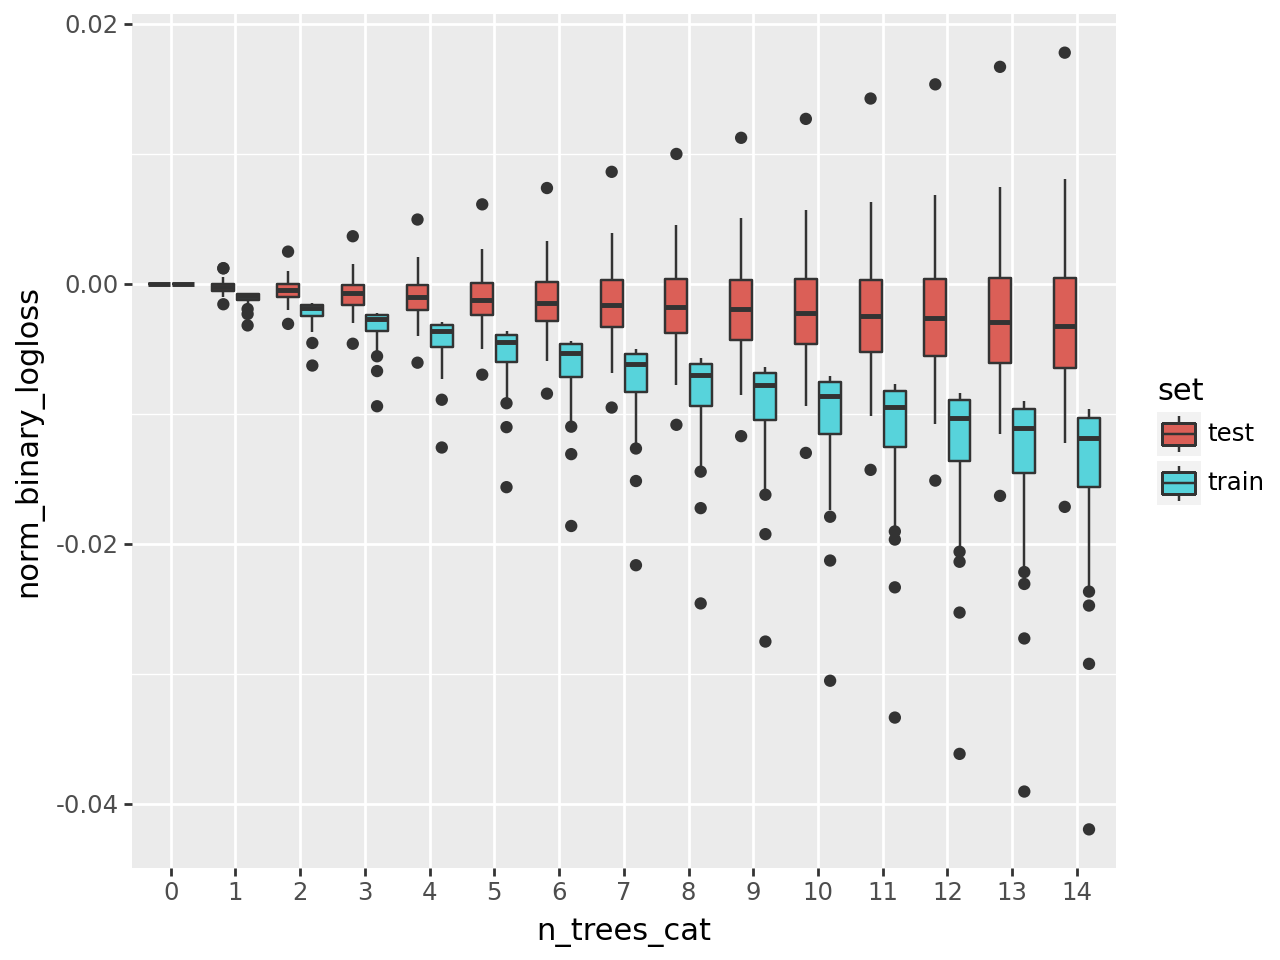

In [56]:
all_results_15, all_predicted_tickers_15, all_models_15 = results_hyp[15]
train_lc_15 = return_norm_learning_curves("training", all_results_15)
train_lc_15["n_trees_cat"] = pd.Categorical(
    train_lc_15["n_trees"], categories=sorted(train_lc_15["n_trees"].unique())
)
test_lc_15 = return_norm_learning_curves("valid_0", all_results_15)
test_lc_15["n_trees_cat"] = pd.Categorical(
    test_lc_15["n_trees"], categories=sorted(test_lc_15["n_trees"].unique())
)
train_lc_15["set"] = "train"
test_lc_15["set"] = "test"
data_15_lc = pd.concat([train_lc_15, test_lc_15])
(
    ggplot(data_15_lc, aes(x="n_trees_cat", y="norm_binary_logloss", fill="set"))
    + geom_boxplot()
)

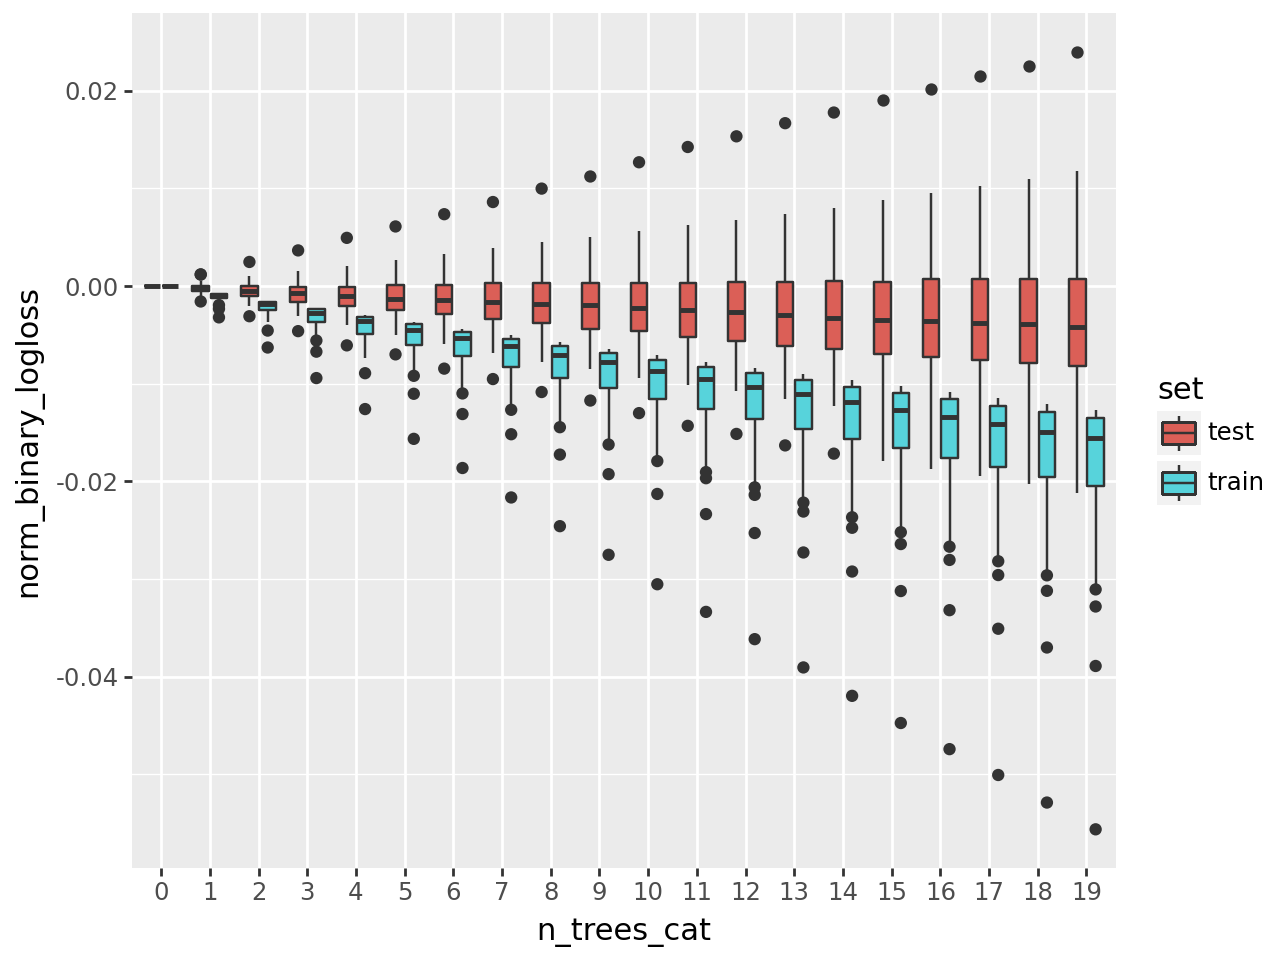

In [57]:
all_results_20, all_predicted_tickers_20, all_models_20 = results_hyp[20]
train_lc_20 = return_norm_learning_curves("training", all_results_20)
train_lc_20["n_trees_cat"] = pd.Categorical(
    train_lc_20["n_trees"], categories=sorted(train_lc_20["n_trees"].unique())
)
test_lc_20 = return_norm_learning_curves("valid_0", all_results_20)
test_lc_20["n_trees_cat"] = pd.Categorical(
    test_lc_20["n_trees"], categories=sorted(test_lc_20["n_trees"].unique())
)
train_lc_20["set"] = "train"
test_lc_20["set"] = "test"
data_20_lc = pd.concat([train_lc_20, test_lc_20])
(
    ggplot(data_20_lc, aes(x="n_trees_cat", y="norm_binary_logloss", fill="set"))
    + geom_boxplot()
)

As it continue learning with 20 trees, the hyperparameter chosen is n_estimators = 20

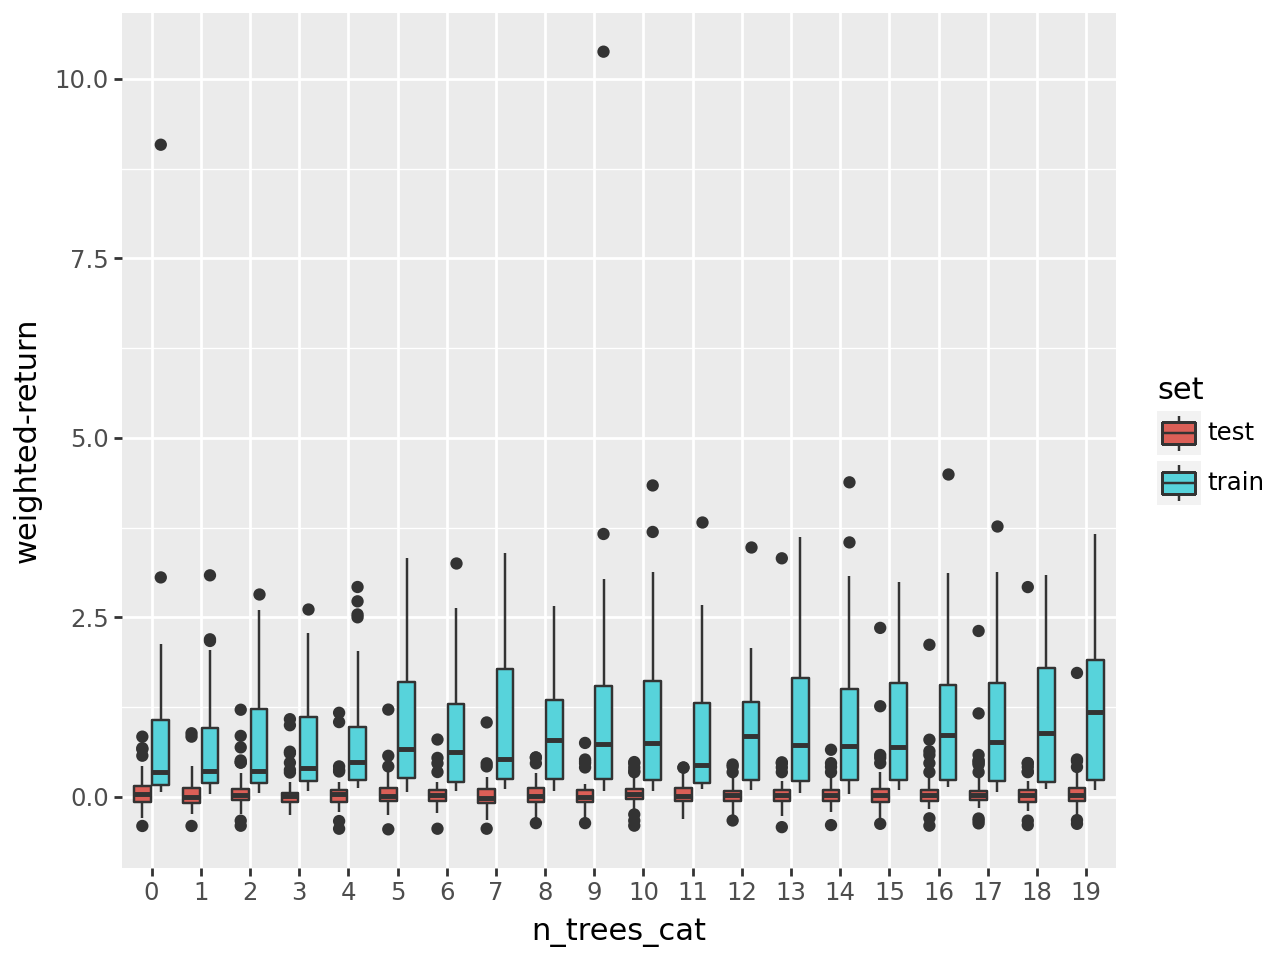

In [208]:
(
    ggplot(data_20_lc, aes(x="n_trees_cat", y="weighted-return", fill="set"))
    + geom_boxplot()
)

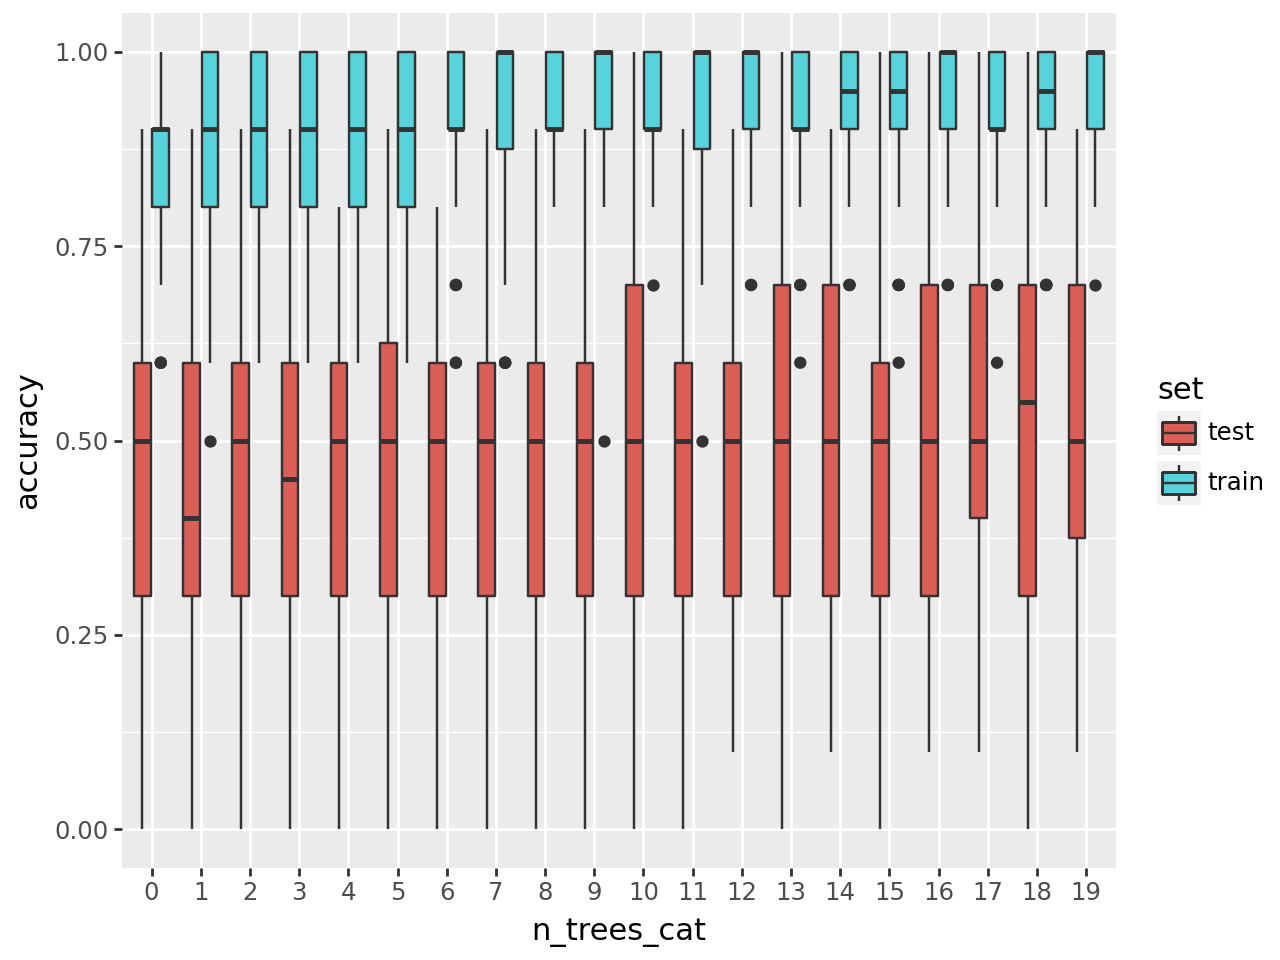

In [209]:
ggplot(data_20_lc, aes(x="n_trees_cat", y="accuracy", fill="set")) + geom_boxplot()

The accuracy metric is not very sensitive to changes in the model; for it to be affected, the model's adjustment must lead to changes in the top_n stocks. Since accuracy is discrete, it is possible that these hyperparameter adjustments are not producing enough changes to be reflected, but there may come a point where the change in accuracy becomes abrupt.

In [109]:
len(data_set["execution_date"].unique())

64

# Data importance

In [58]:
from sklearn.inspection import permutation_importance
import pandas as pd


def train_model_fi(train_set, test_set, params, compute_importance=False):

    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    model = lgb.LGBMClassifier(**params)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

    eval_result = {}

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test), (X_train, y_train)],
        eval_metric=[top_wt_performance, top_accuracy],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )

    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame(
            {"importance": r.importances_mean, "feature": feature_names}
        )
    else:
        df_permutation_importance = pd.DataFrame()

    return model, eval_result, X_train, X_test, df_permutation_importance

In [59]:
def run_model_for_execution_date_fi(
    execution_date,
    all_results,
    all_predicted_tickers_list,
    all_models,
    params,
    include_nulls_in_test=False,
):
    global train_set
    global test_set
    global all_permutation_importances
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = train_set
    X_test = test_set

    # if both train and test are not empty
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test, df_permutation_importances = (
            train_model_fi(train_set, test_set, params=params, compute_importance=True)
        )
        if type(model) == lgb.sklearn.LGBMClassifier:
            model = model.booster_
        test_set["prob"] = model.predict(X_test)
        predicted_tickers = test_set.sort_values("prob", ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
        df_permutation_importances["execution_date"] = execution_date
        all_permutation_importances = pd.concat(
            [all_permutation_importances, df_permutation_importances]
        )
    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test


execution_dates = np.sort(data_set["execution_date"].unique())

In [60]:
def train_model_across_periods_fi(train_period_frequency=1, compute_importance=False):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    for i, execution_date in enumerate(execution_dates):
        print(execution_date)
        all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = (
            run_model_for_execution_date_fi(
                execution_date,
                all_results,
                all_predicted_tickers_list,
                all_models,
                params,
                False,
            )
        )

    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

In [61]:
execution_dates = np.sort(data_set["execution_date"].unique())
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 10e-3,
    "path_smooth": 0.2,
    "n_estimators": 20,
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_across_periods_fi(compute_importance=True)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [62]:
all_permutation_importances = all_permutation_importances.sort_values(
    ["execution_date", "importance"], ascending=True
)

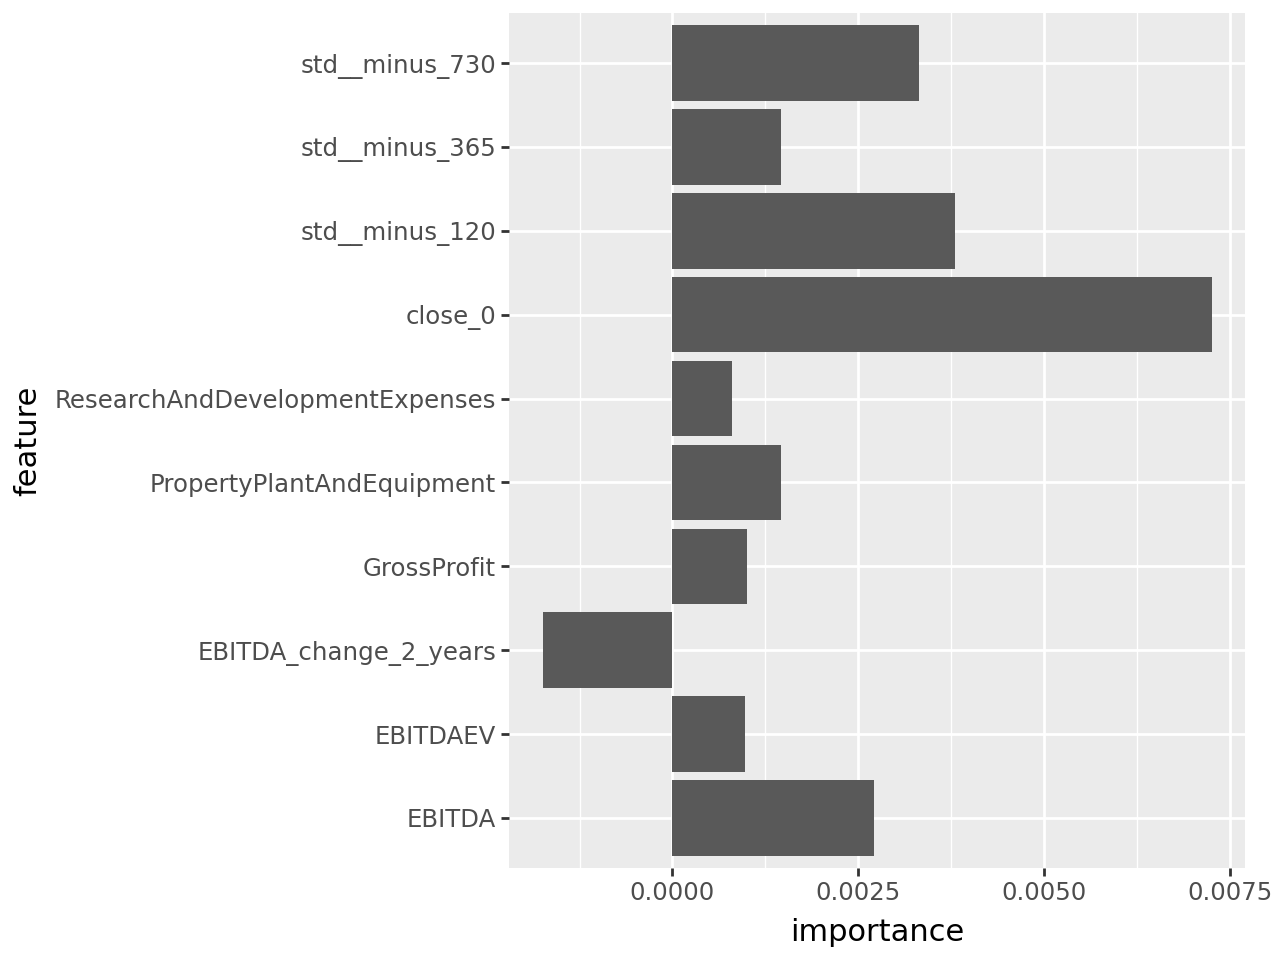

In [63]:
all_permutation_importances_sum = (
    all_permutation_importances.groupby(["feature"])["importance"].mean().reset_index()
)
all_permutation_importances_sum = all_permutation_importances_sum.sort_values(
    by="importance", key=np.abs, ascending=False
)
(
    ggplot(all_permutation_importances_sum.head(10))
    + geom_col(aes(x="feature", y="importance"))
    + coord_flip()
)

close_0 has a suspiciously high value. This is because, due to the reverse splits of those stocks that have had significant drops, the model is learning that a high price means that a reverse split will happen in the future because the price will become too low, so it assigns a low probability. As this has been studied in class , I'm going to study std__minus120 (the second higuest feature) to see its values in specific cases.

C:\Users\rfran\AppData\Local\Temp\ipykernel_14800\2027957441.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


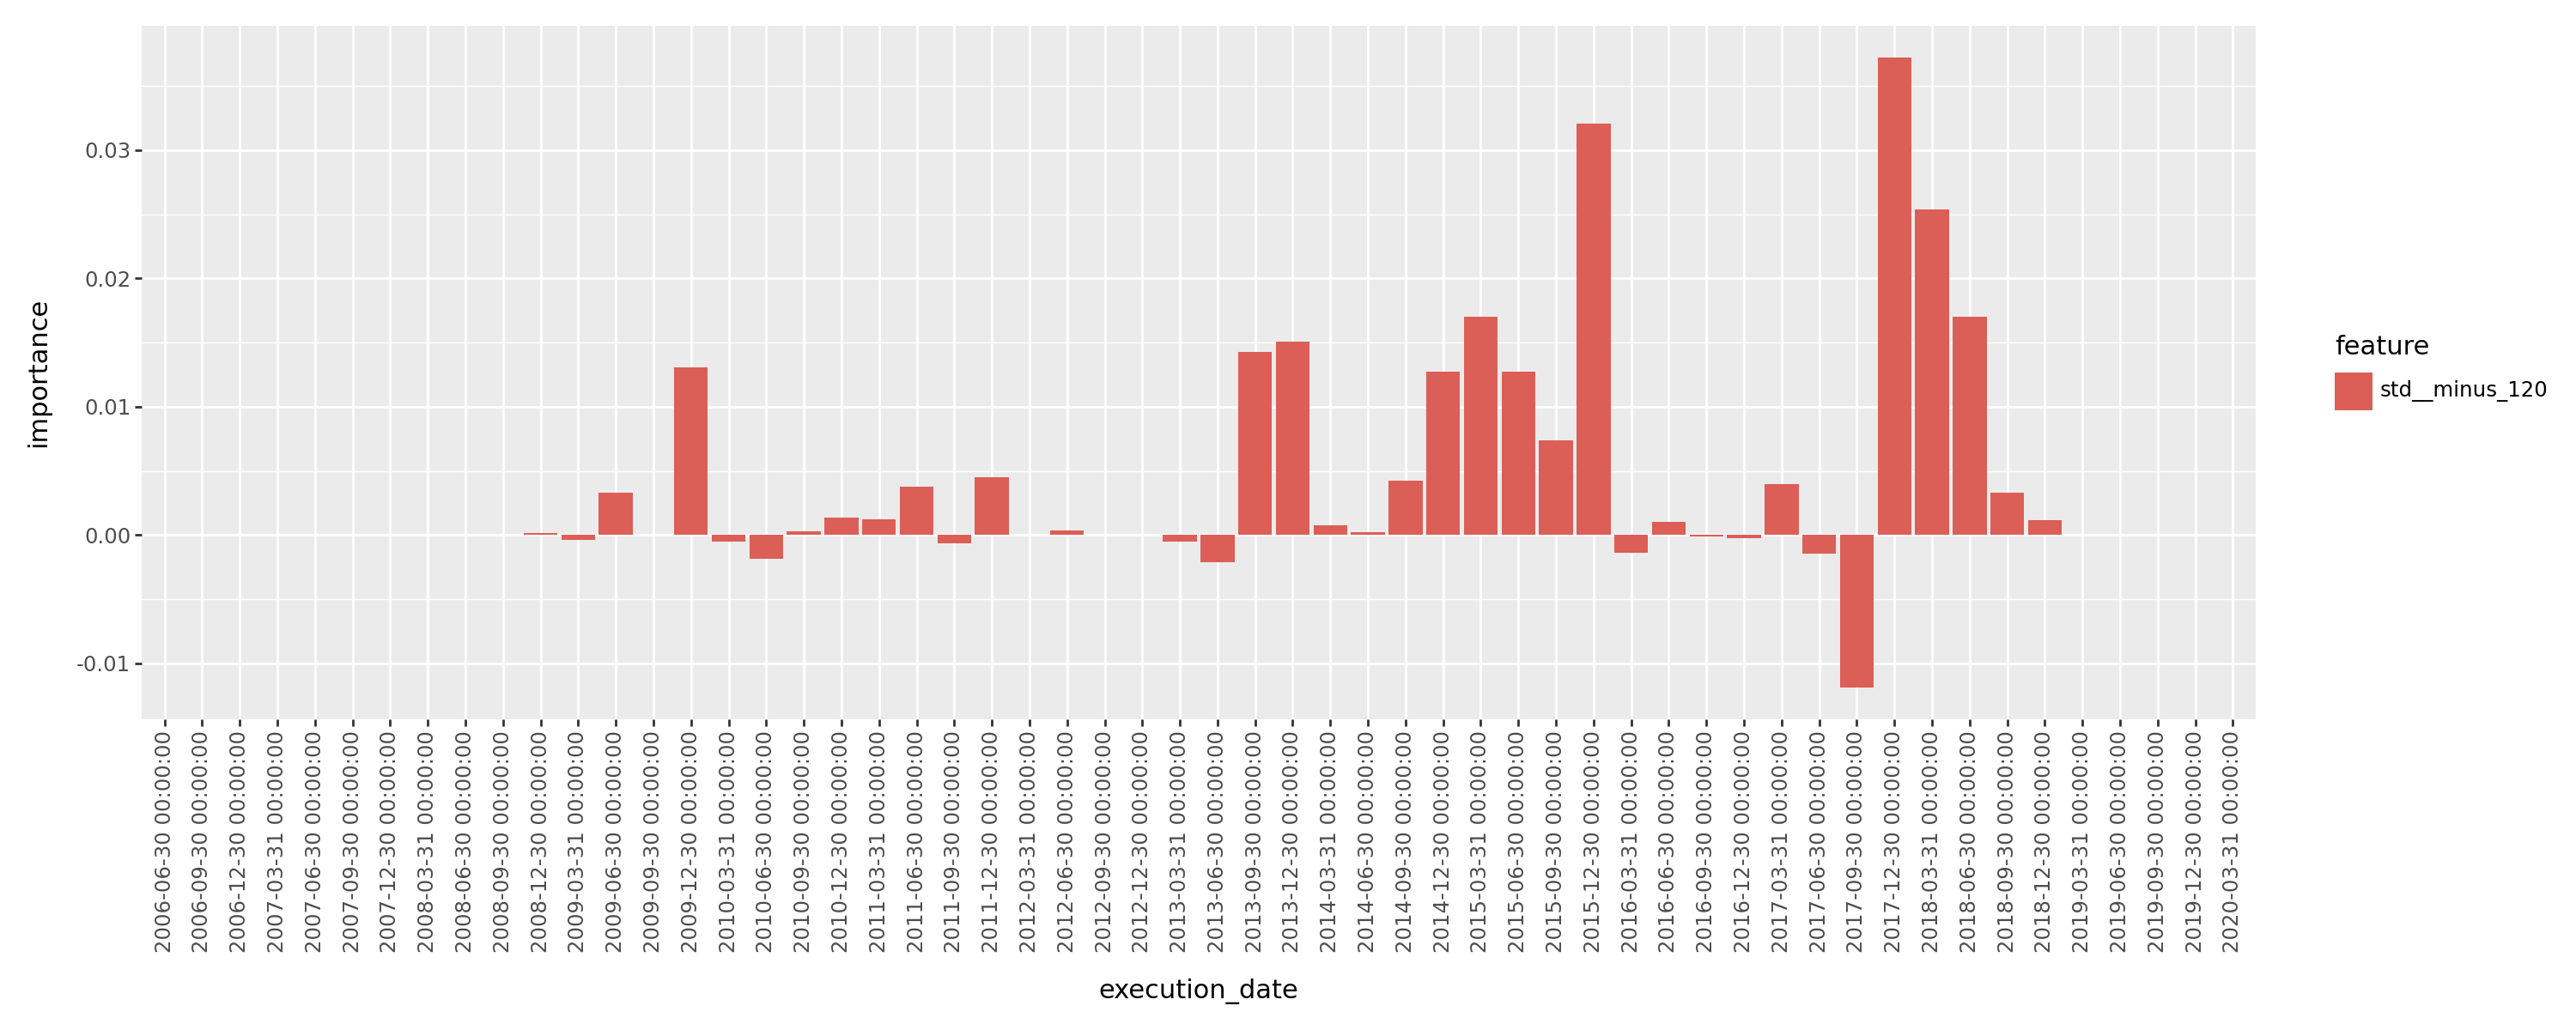

In [ ]:
from plotnine import scale_x_discrete

# Representation of the top mean important of feature='std__minus_120' each execution date
mean_std_minus_120_importances = all_permutation_importances.loc[
    lambda x: x.feature == "std__minus_120"
]

mean_std_minus_120_importances["execution_date"] = pd.Categorical(
    mean_std_minus_120_importances["execution_date"],
    categories=sorted(mean_std_minus_120_importances["execution_date"].unique()),
)
(
    ggplot(
        mean_std_minus_120_importances,
        aes(x="execution_date", y="importance", fill="feature"),
    )
    + geom_col()
    + theme(axis_text_x=element_text(rotation=90), figure_size=(15, 6))
)

- It's appreciated how the importance of std__minus_120 grows its importance. Let's study the greatest value in execution_date = '2017-12-30'.

In [130]:
all_permutation_importances[
    all_permutation_importances["execution_date"] == "2017-12-30"
].sort_values(by="importance", ascending=False)

,importance,feature,execution_date
99,0.037241,std__minus_120,2017-12-30
101,0.018180,std__minus_730,2017-12-30
62,0.016789,PropertyPlantAndEquipment,2017-12-30
87,0.005256,close_0,2017-12-30
12,0.004906,CostOfGoodsSold,2017-12-30
...,...,...,...
0,-0.000478,AssetTurnover,2017-12-30
100,-0.001264,std__minus_365,2017-12-30
114,-0.001444,ROC,2017-12-30
17,-0.002984,EBIT,2017-12-30


Let's study the feature in each ticker in that execution_date

In [191]:
# Shap diagram to see the performance of all the ticker/specific ticker in a execution_date
import shap


def get_shap_values_for_ticker_execution_date(execution_date, ticker=None):
    date = np.datetime64(execution_date)
    model_ = all_models[date]
    fn = model_.feature_name()
    X_test = all_predicted_tickers[(all_predicted_tickers["execution_date"] == date)]
    if ticker is not None:
        X_test = X_test[X_test["Ticker"] == ticker]

    X_test["Ticker"] = X_test["Ticker"].astype("category")
    X_test = X_test.sort_values("Ticker")

    if ticker is not None:
        explainer = shap.Explainer(model_)
        shap_values = explainer(X_test[fn])

    else:
        explainer = shap.Explainer(model_, X_test[fn])
        shap_values = explainer(X_test[fn])
    return shap_values

C:\Users\rfran\AppData\Local\Temp\ipykernel_14800\2663114212.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


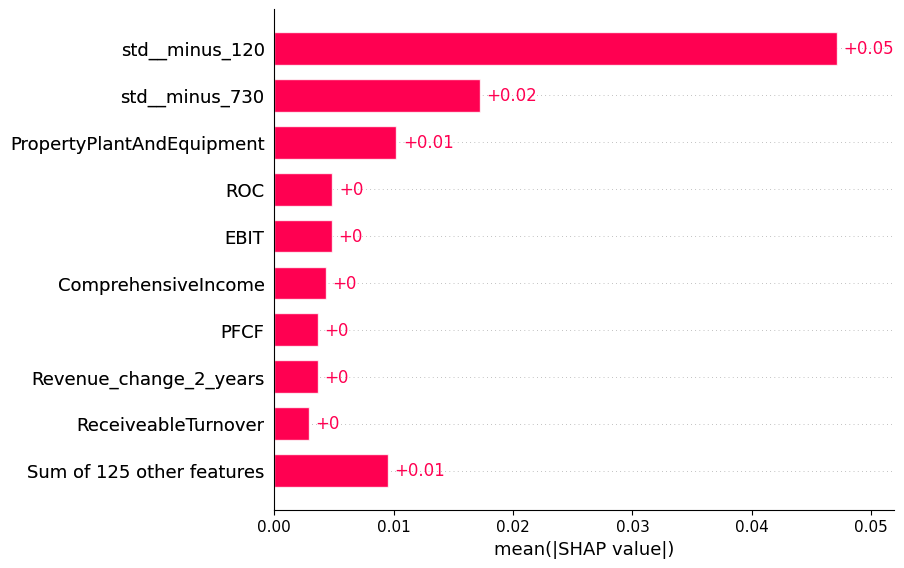

In [192]:
sv = get_shap_values_for_ticker_execution_date("2017-12-30T00:00:00.000000000")
shap.plots.bar(sv)

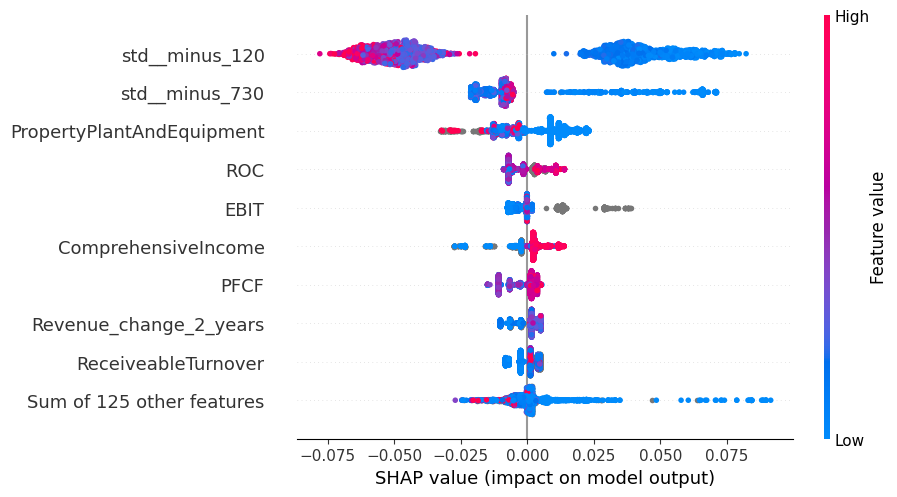

In [193]:
shap.plots.beeswarm(sv)

- As it has sense, a lower std__minus_120 means a lower volality change and more posibilities to suceed.
- Studying specdific cases to support this previous plot, the model gives those tickers with higuer std__minus_120 value a negative std__minus_120 importance that lows the probabily to suceed and the ones with lower std__minus_120 value a high positive std__minus_120

In [213]:
tickers = (
    all_predicted_tickers[all_predicted_tickers["execution_date"] == "2017-12-30"]
    .dropna(subset=["std__minus_120"])
    .sort_values(by="std__minus_120", ascending=False)
    .reset_index()
)
highest_std__minus_120_ticker = tickers.loc[0, ["Ticker", "std__minus_120"]]
lowest_std__minus_120_ticker = tickers.iloc[-1][["Ticker", "std__minus_120"]]
print(highest_std__minus_120_ticker)
print(lowest_std__minus_120_ticker)

Ticker               LIVX
std__minus_120    0.28174
Name: 0, dtype: object
Ticker                AESE
std__minus_120    0.001586
Name: 3137, dtype: object


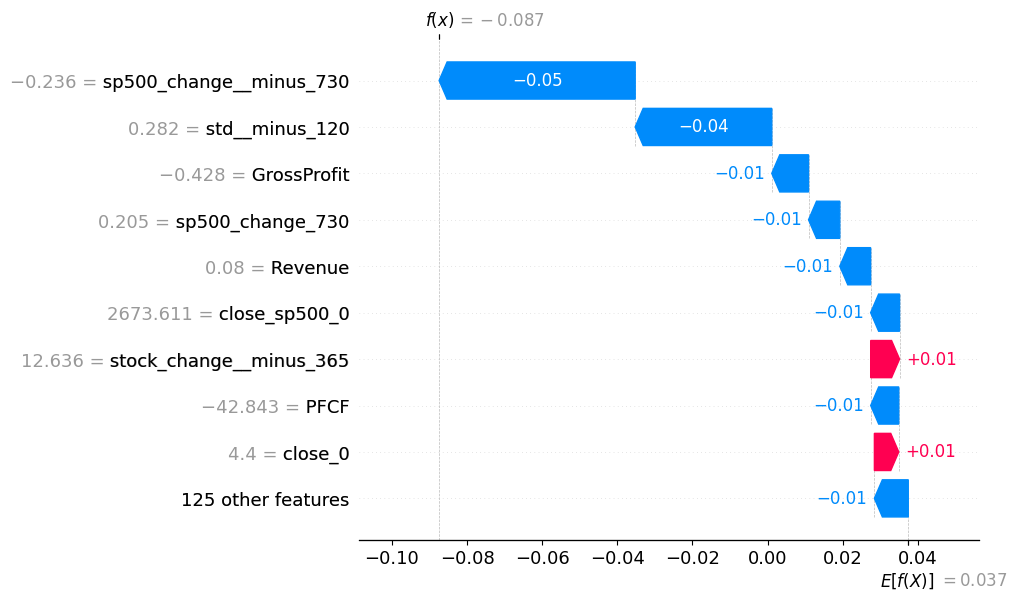

In [195]:
sv = get_shap_values_for_ticker_execution_date(
    "2017-12-30T00:00:00.000000000", ticker="LIVX"
)
shap.plots.waterfall(sv[0])

Como se esperaba, el ticker con mayor valor de std__minus_120 tine como feature importance un valor muy negativo que disminuye la probabilidad de éxito

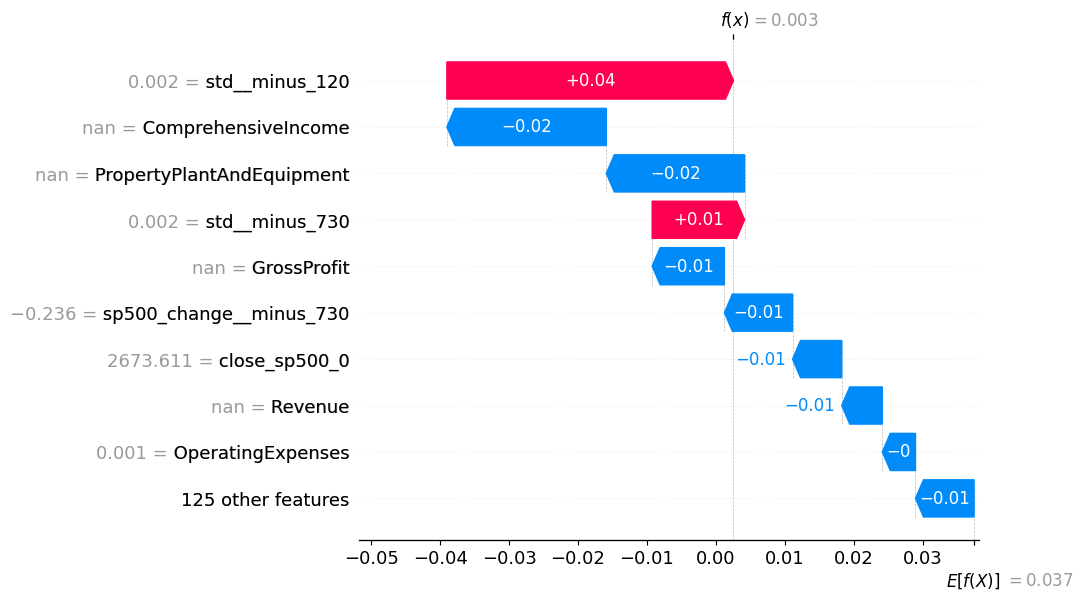

In [196]:
sv = get_shap_values_for_ticker_execution_date(
    "2017-12-30T00:00:00.000000000", ticker="AESE"
)
shap.plots.waterfall(sv[0])

In [217]:
all_permutation_importances_sum.shape

(134, 2)

# Retraining

Retraining without close_0 and with the 100 highest mean_permutation_importance value 

In [64]:
retraining_colums = all_permutation_importances_sum[["feature"]].head(100)
retraining_colums = retraining_colums.drop(
    retraining_colums[retraining_colums["feature"] == "close_0"].index
)
retraining_colums = retraining_colums["feature"].tolist()
retraining_colums

['std__minus_120',
 'std__minus_730',
 'EBITDA',
 'EBITDA_change_2_years',
 'std__minus_365',
 'PropertyPlantAndEquipment',
 'GrossProfit',
 'EBITDAEV',
 'ResearchAndDevelopmentExpenses',
 'EPS_minus_EarningsPerShare_change_2_years',
 'EBITDA_change_1_years',
 'GrossMargin',
 'RevenueEV',
 'stock_change__minus_730',
 'Receivables',
 'OperatingExpenses',
 'Revenue',
 'Pre_minus_TaxIncome',
 'Revenue_change_2_years',
 'DaysSalesInReceivables',
 'EBITEV',
 'Stock_minus_BasedCompensation',
 'SGAExpenses',
 'CostOfGoodsSold',
 'FreeCashFlowPerShare_change_2_years',
 'TotalLongTermLiabilities',
 'DebtEquityRatio',
 'TotalLong_minus_TermAssets',
 'TotalNon_minus_OperatingIncomeExpense',
 'stock_change_div__minus_365',
 'DividendYieldLastYear',
 'TotalLiabilities',
 'IncomeTaxes',
 'OperatingMargin',
 'Market_cap',
 'EBITMargin',
 'Long_minus_TermInvestments',
 'CashFlowFromOperatingActivities',
 'EBIT',
 'AssetTurnover',
 'Revenue_change_1_years',
 'NetChangeInPropertyPlantAndEquipment',
 'Ca

In [65]:
import warnings

warnings.filterwarnings("ignore")


def train_model(train_set, test_set, params):

    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    X_train = X_train.loc[:, retraining_colums]
    X_test = X_test.loc[:, retraining_colums]
    # print(retraining_colums.shape)
    # print(X_train.shape)
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance, top_accuracy],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result, X_train, X_test

In [66]:
def train_model_across_periods(params):
    all_results = {}
    all_predicted_tickers_list = []
    all_models = {}

    for execution_date in execution_dates:
        print(execution_date)
        all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = (
            run_model_for_execution_date(
                execution_date,
                all_results,
                all_predicted_tickers_list,
                all_models,
                params,
                False,
            )
        )
    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

    return all_results, all_predicted_tickers_list, all_predicted_tickers, all_models

In [67]:
lrs = [10e-3]
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": lrs,
    "path_smooth": 0.2,
    "n_estimators": 20,
}

print(f"Training model with top 99 features")
(
    all_results_fi,
    all_predicted_tickers_list_fi,
    all_predicted_tickers_fi,
    all_models_fi,
) = train_model_across_periods(params)

Training model with top 99 features
2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013

In [68]:
def parse_results_into_df(all_results_data, set_):
    df = pd.DataFrame()
    for date in all_results_data:
        df_tmp = pd.DataFrame(all_results_data[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    df["execution_date"] = df["execution_date"].astype(str)

    return df

In [69]:
test_results_def = parse_results_into_df(all_results_fi, "valid_0")
train_results_def = parse_results_into_df(all_results_fi, "training")

In [70]:
test_results_final_tree_def = test_results_def.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree_def = train_results_def.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
test_results_final_tree_def["execution_date"] = pd.to_datetime(
    test_results_final_tree_def["execution_date"]
)
train_results_final_tree_def["execution_date"] = pd.to_datetime(
    train_results_final_tree_def["execution_date"]
)

In [87]:
test_results_final_tree_model_def_vs_baseline = pd.merge(
    test_results_final_tree_def, baseline, on="execution_date"
)
test_results_final_tree_model_def_vs_baseline

,binary_logloss,weighted-return,accuracy,n_trees,execution_date,diff_ch_sp500_baseline
0,0.718138,0.057164,0.8,19,2006-06-30,-0.051974
1,0.703592,-0.004930,0.4,19,2006-09-30,0.284753
2,0.714118,0.070627,0.5,19,2006-12-30,-0.004236
3,0.702505,-0.027278,0.6,19,2007-03-31,-0.245538
4,0.694702,-0.060404,0.3,19,2007-06-30,-0.318742
5,0.697627,-0.079718,0.2,19,2007-09-30,0.116051
6,0.703367,0.017385,0.4,19,2007-12-30,-0.251380
7,0.695990,-0.052333,0.3,19,2008-03-31,-0.104486
8,0.703048,-0.066797,0.4,19,2008-06-30,0.432996
9,0.696480,0.017459,0.7,19,2008-09-30,3.729805


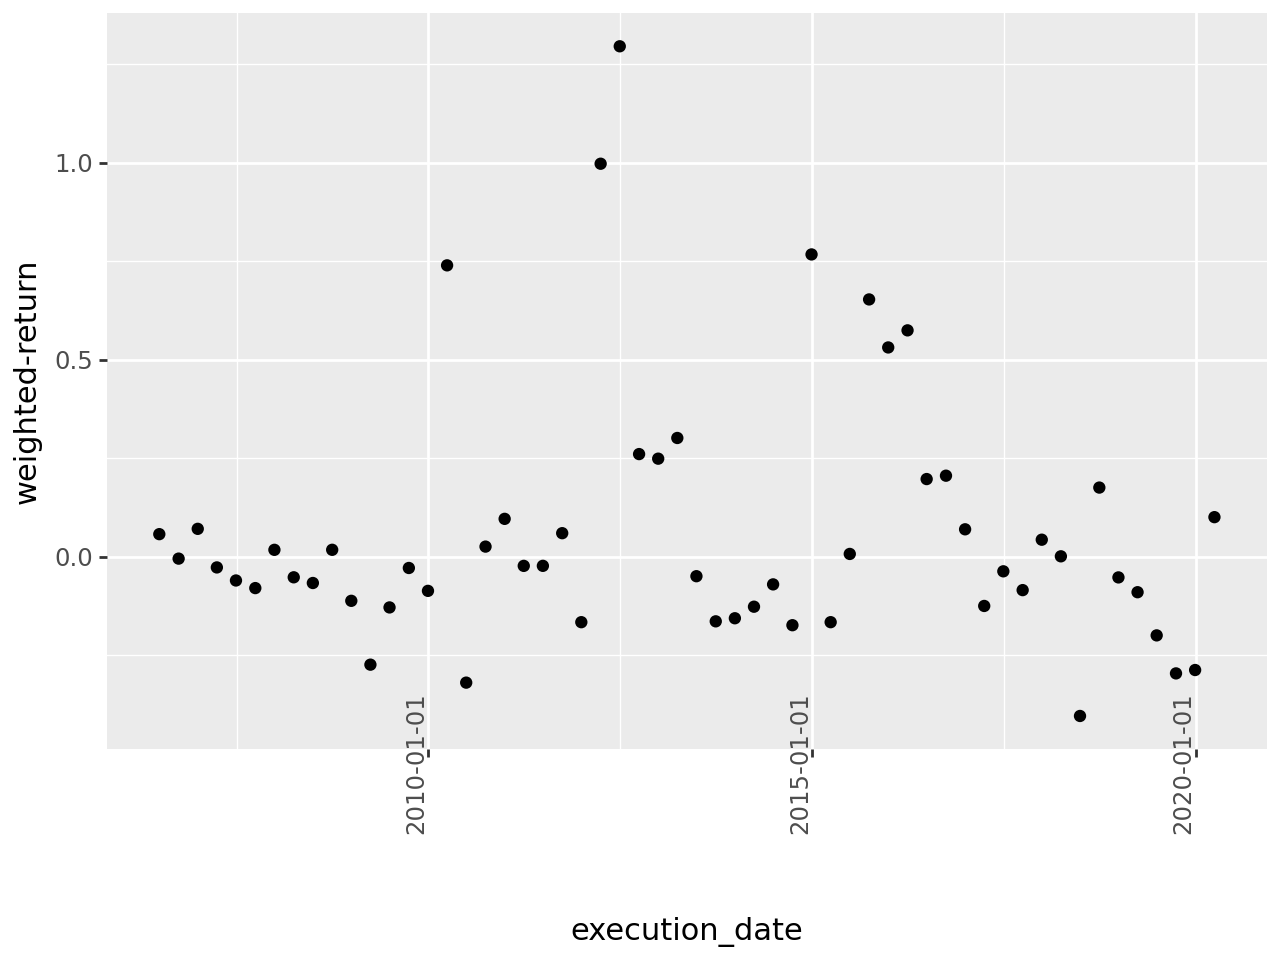

In [88]:
(
    ggplot(test_results_final_tree_def)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

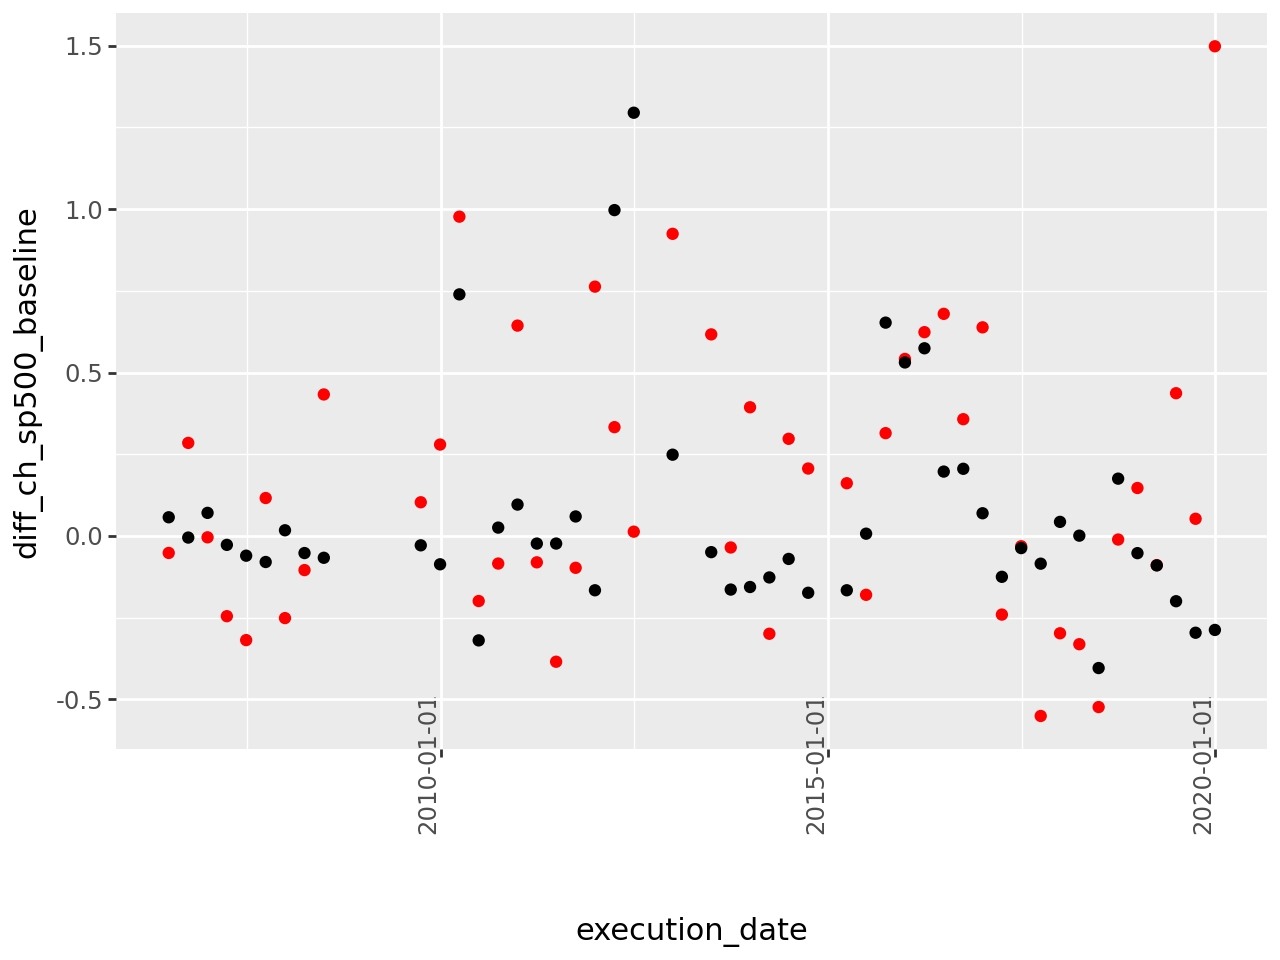

In [ ]:
(
    ggplot(
        test_results_final_tree_model_def_vs_baseline[
            test_results_final_tree_model_def_vs_baseline["diff_ch_sp500_baseline"] < 2
        ],
        aes(x="execution_date"),
    )
    + geom_point(aes(y="diff_ch_sp500_baseline"), color="red")
    + geom_point(aes(y="weighted-return"), color="black")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

All the values are really close to 0, the baseline seems to have more points lower than the model

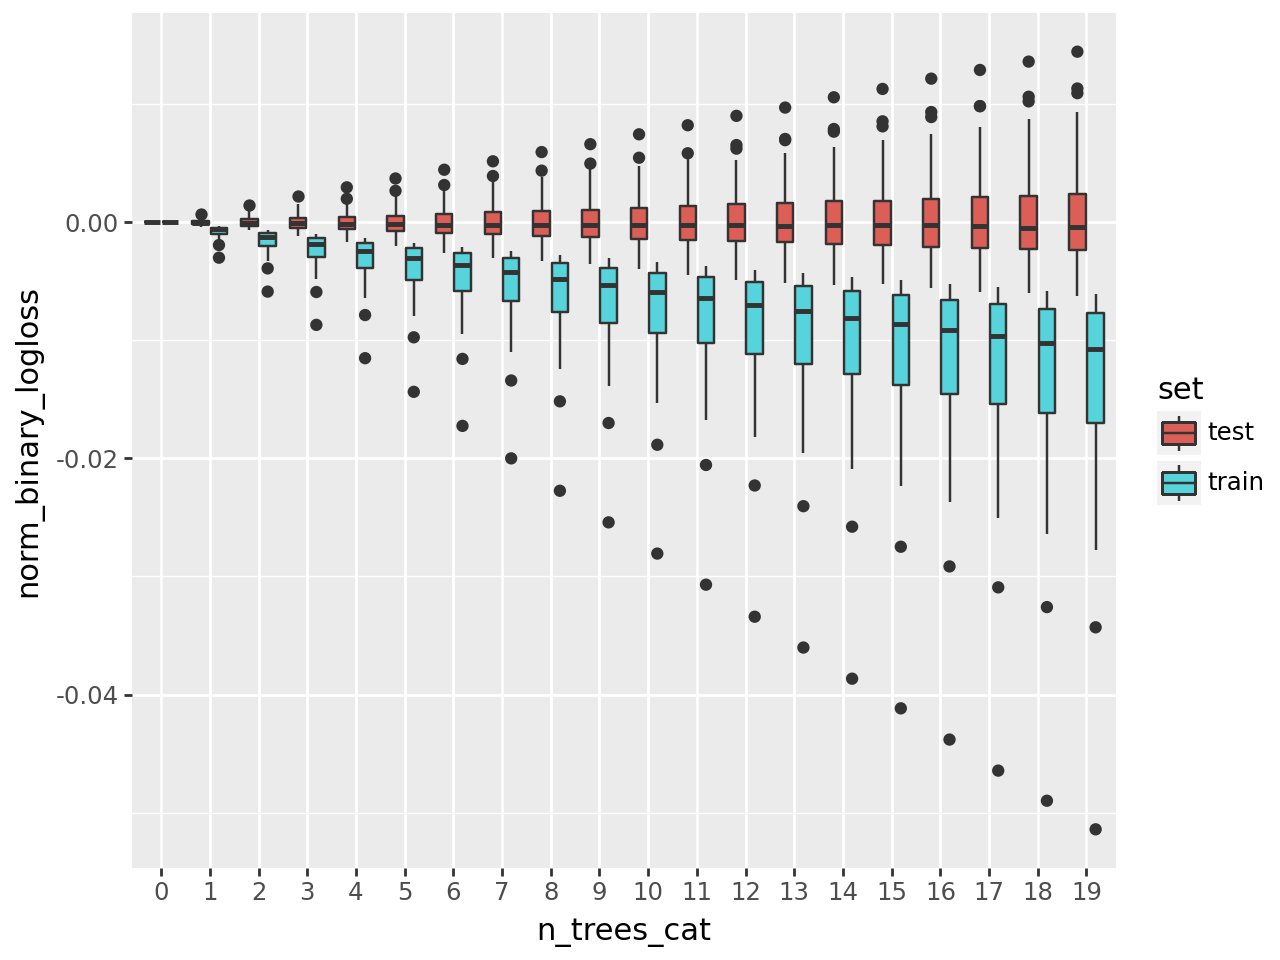

In [105]:
# Visualizng and comparing with all the features:

train_lc_fi = return_norm_learning_curves("training", all_results_fi)
train_lc_fi["n_trees_cat"] = pd.Categorical(
    train_lc_fi["n_trees"], categories=sorted(train_lc_fi["n_trees"].unique())
)
test_lc_fi = return_norm_learning_curves("valid_0", all_results_fi)
test_lc_fi["n_trees_cat"] = pd.Categorical(
    test_lc_fi["n_trees"], categories=sorted(test_lc_fi["n_trees"].unique())
)
train_lc_fi["set"] = "train"
test_lc_fi["set"] = "test"
data_fi_lc = pd.concat([train_lc_fi, test_lc_fi])
(
    ggplot(data_fi_lc, aes(x="n_trees_cat", y="norm_binary_logloss", fill="set"))
    + geom_boxplot()
)

- Without data leackeage, medians and Q3 are have worse performance
- Let's study if this also happens in weighted-return and accuracy

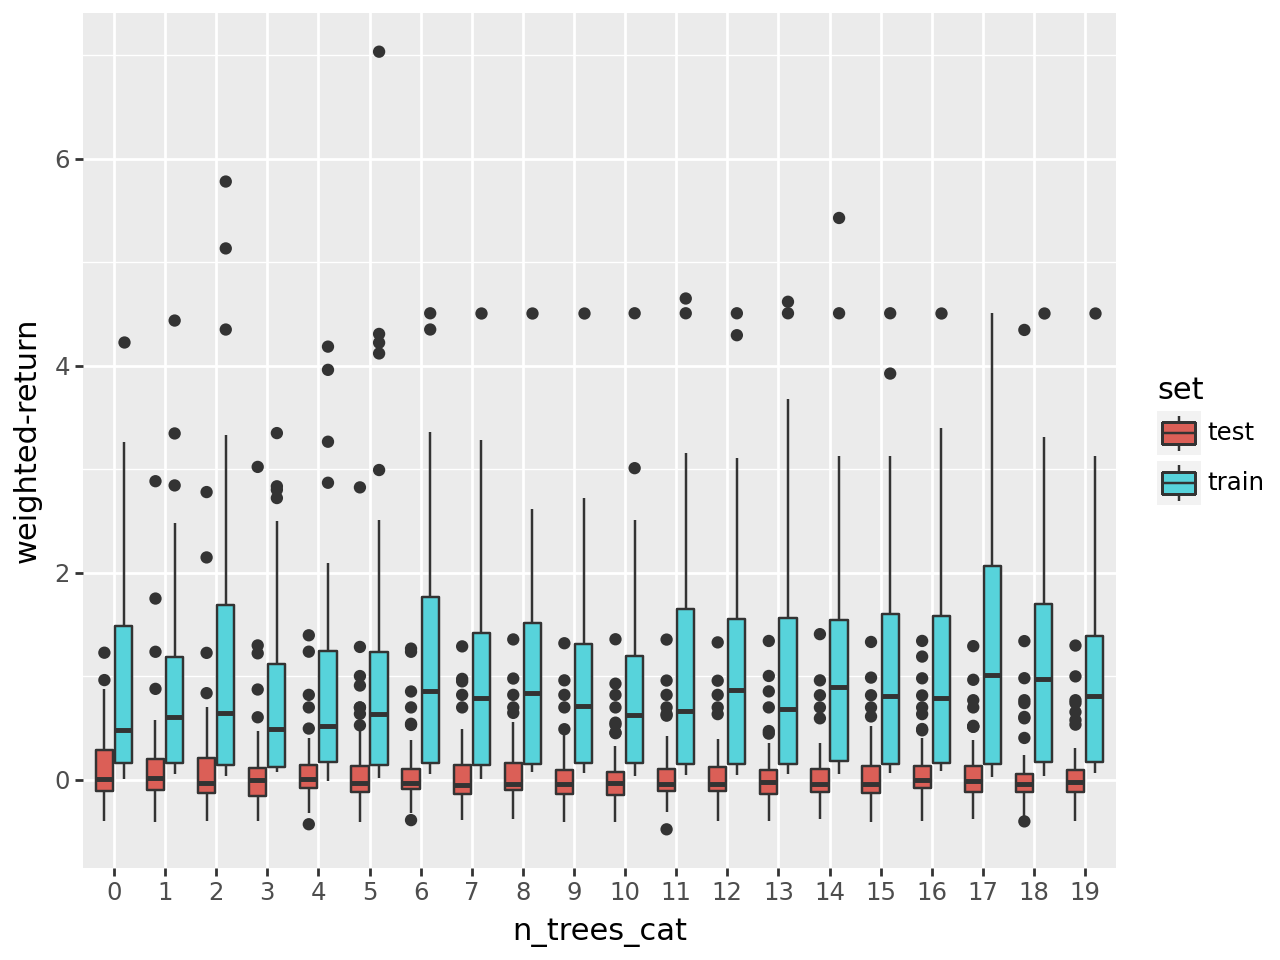

In [106]:
(
    ggplot(data_fi_lc, aes(x="n_trees_cat", y="weighted-return", fill="set"))
    + geom_boxplot()
)

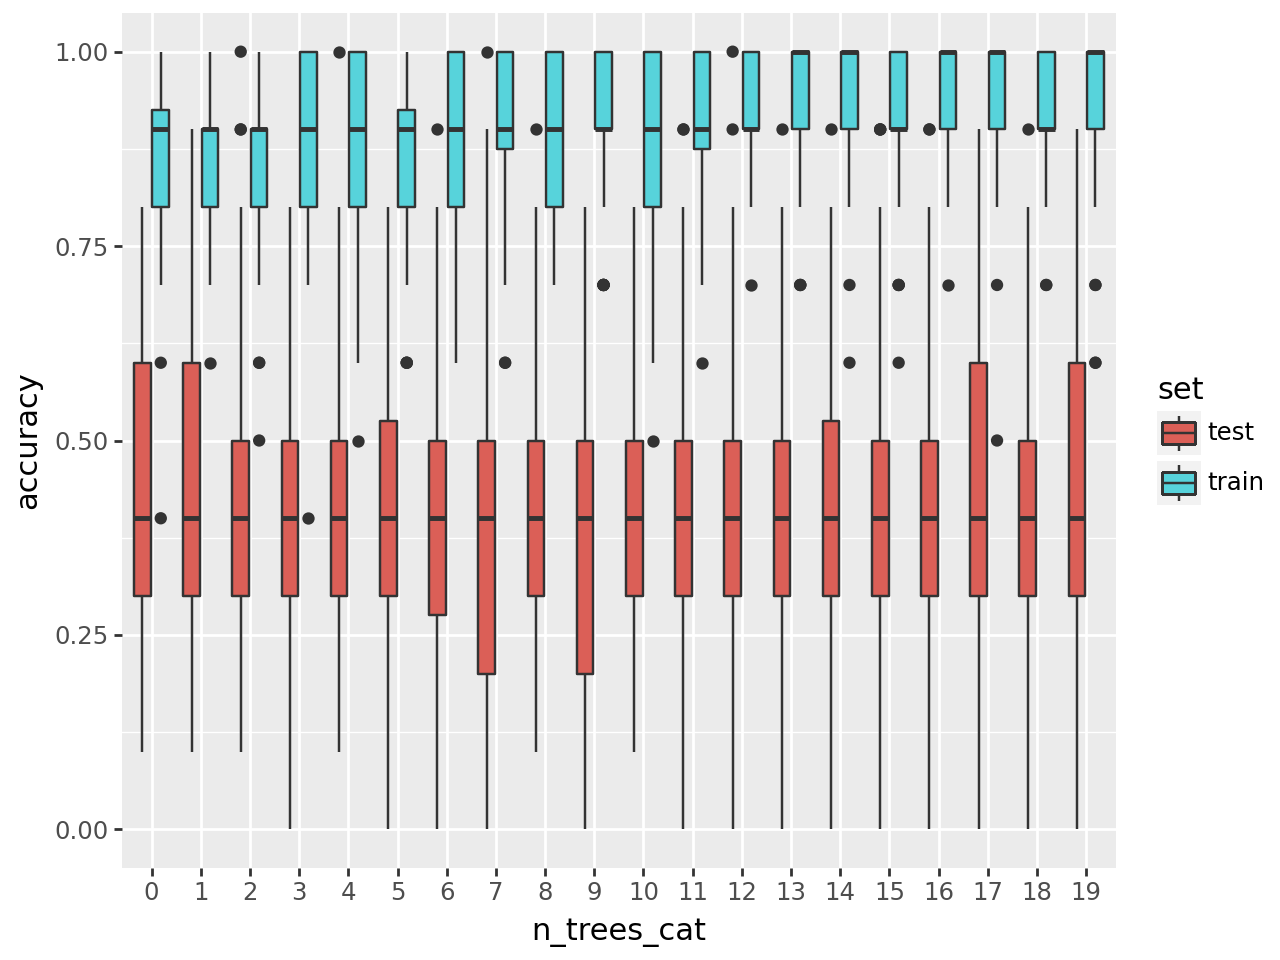

In [107]:
ggplot(data_fi_lc, aes(x="n_trees_cat", y="accuracy", fill="set")) + geom_boxplot()

- In this case, the accuracy shows median values =0.4 never obtained with all the features.


# Quarters reduction

Retraining with less quarters and measure the logloss performance/final to compare with different n_quarters. Include the knowledge of the different distributions trainig/val.

In [122]:
n_train_quarters = 12
# repetir el apartado de retrainig anterior de nuevo
lrs = [10e-3]
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": lrs,
    "path_smooth": 0.2,
    "n_estimators": 20,
}

print(f"Training model with top 89 features and 12 quarters")
(
    all_results_12_quar,
    all_predicted_tickers_list_12_quar,
    all_predicted_tickers_12_quar,
    all_models_12_quar,
) = train_model_across_periods(params)

Training model with top 89 features and 12 quarters
2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:0

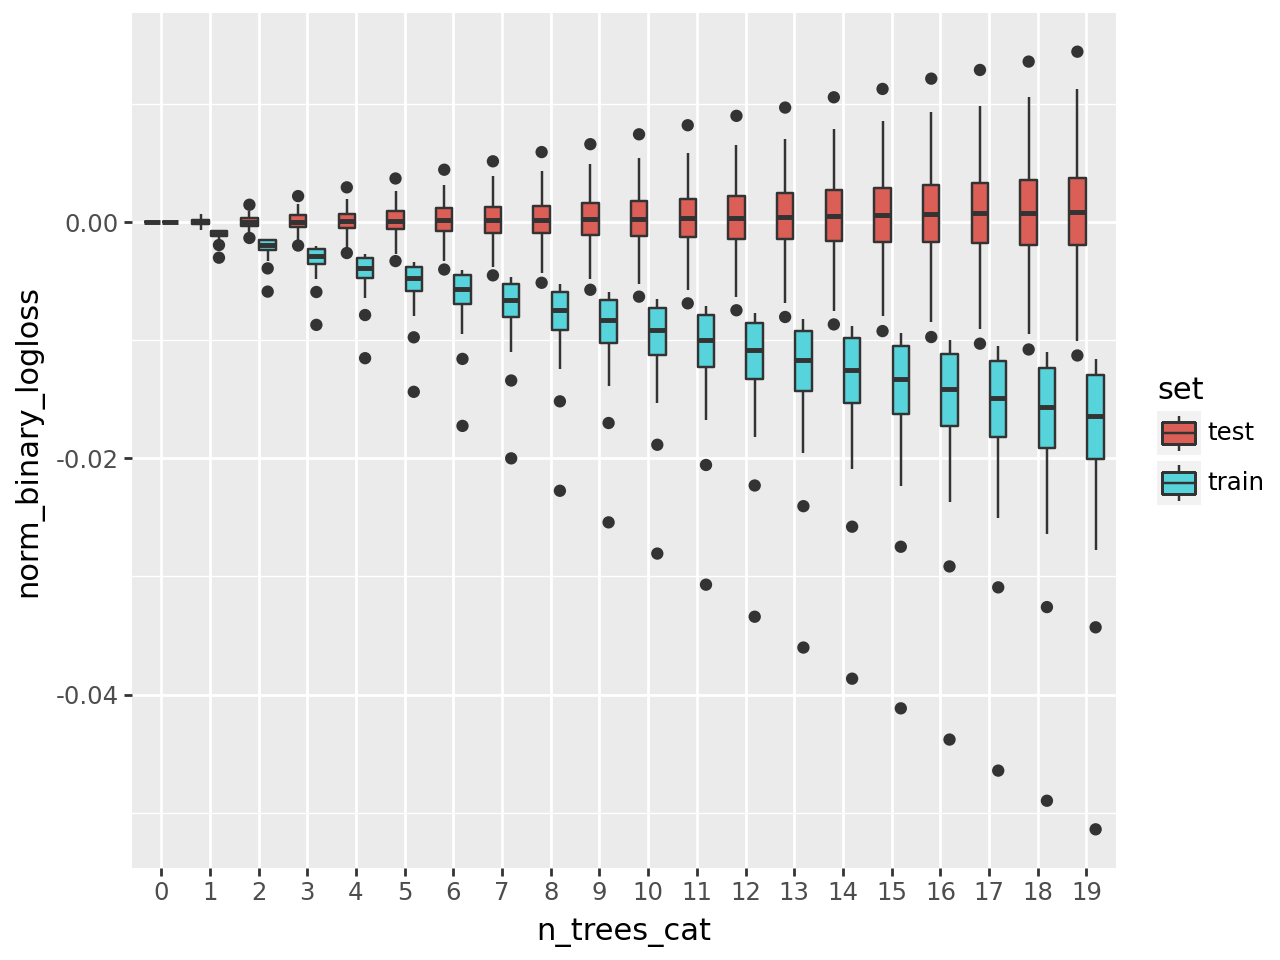

In [123]:
train_lc_12_quar = return_norm_learning_curves("training", all_results_12_quar)
train_lc_12_quar["n_trees_cat"] = pd.Categorical(
    train_lc_12_quar["n_trees"], categories=sorted(train_lc_12_quar["n_trees"].unique())
)
test_lc_12_quar = return_norm_learning_curves("valid_0", all_results_12_quar)
test_lc_12_quar["n_trees_cat"] = pd.Categorical(
    test_lc_12_quar["n_trees"], categories=sorted(test_lc_12_quar["n_trees"].unique())
)
train_lc_12_quar["set"] = "train"
test_lc_12_quar["set"] = "test"
data_12_quar = pd.concat([train_lc_12_quar, test_lc_12_quar])
(
    ggplot(data_12_quar, aes(x="n_trees_cat", y="norm_binary_logloss", fill="set"))
    + geom_boxplot()
)

- Medians and Q3 are above 0, which is different from when n_train_quarters=36.

# Temporal evolution of the number of good stocks

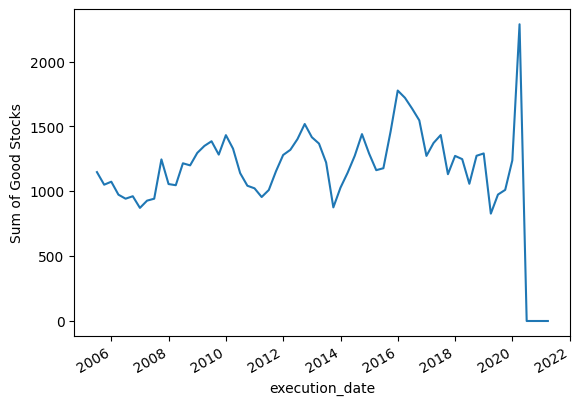

In [79]:
import matplotlib.pyplot as plt

data_set.groupby("execution_date")["target"].sum().plot(kind="line")
plt.ylabel("Sum of Good Stocks")
plt.show()

The number of good stocks remains steady over time.